
# AI-Driven Patient Triage System for Emergency Departments

Emergency Departments (EDs) are high-pressure environments where fast and accurate triage decisions are critical to patient outcomes. Triage nurses must quickly assess a patient's condition and assign a severity level to prioritize treatment. Inconsistent decision-making, long wait times, and overcrowding can compromise care quality. An AI-driven decision support system can assist in these scenarios by providing real-time analysis and predictions, improving both the accuracy and efficiency of triage.

**Objective**: The goal is to develop an AI-powered decision support system that helps emergency department personnel classify incoming patients into triage categories based on their symptoms, vital signs, and other clinical data. This system aims to reduce triage time, improve the accuracy of severity assessments, and optimize resource allocation in the ED.

**Data Source:** The data used is from a retrospective cross-sectional study published in [PLoS One](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0216972#sec019), it was conducted on 1,267 adult patient records admitted to two emergency departments between October 2016 and September 2017, focusing on triage accuracy and the causes of mistriage using the Korean Triage and Acuity Scale (KTAS).

## Table of Contents
1. [Introduction ](#1.-Introduction)  
  
  
2. [Load Dataset](#2.-Load-Dataset)   
       
       
3. [Data Overview](#3.-Data-Overview) 


4. [Data Cleaning and Preprocessing](#4.-Data-Cleaning-and-Preprocessing) 


5. [Exploratory Data Analysis](#5.-Exploratory-Data-Analysis)


6. [Feature Selection and Transformation](#6.-Feature-Selection-and-Transformation)


7. [Baseline Model Development](#7.-Baseline-Model-Development)


8. [Exploring Additional Models](#8.-Exploring-Additional-Models)

9. [Models Evaluation and Selection](#9.Models-Evaluation-and-Selection)

10. [Making New Predictions](#9.Making-New-Predictions)


# 1. Introduction

This notebook is dedicated to exploratory data analysis (EDA) on the KTAS dataset, which contains information about patients attending an emergency department (ED). The primary aim is to analyze various features of the dataset to gain insights into patient demographics, triage classifications, and outcomes.

The ultimate goal of this analysis is to build a predictive model to classify the triage level of patients based on the available features. By identifying patterns and correlations within the data, we aim to enhance healthcare practices and improve patient management in emergency settings.

In [1]:
# Import Libraries
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import warnings  # The warnings module to handle warnings during code execution

# Suppress warnings
warnings.filterwarnings('ignore')

# Import necessary libraries for machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from scipy import stats
import tkinter as tk
from tkinter import messagebox
from sklearn.svm import SVC
import pickle  # For saving and loading models

# 2. Load Dataset

We'll load the dataset and quickly examine its structure to understand the columns and their data types.

In [2]:
# Loading the dataset
data = pd.read_excel('../Data/KTAS_Data.xlsx')

data.head()

,Group,Gender,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71.0,3,3,2,right ocular pain,1,1,2.0,...,36.6,100,2,Corneal abrasion,1,4,2,86.0,5.000000,1
1,1,1,56.0,12,3,2,right forearm burn,1,1,2.0,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64.0,3.950000,1
2,2,1,67.5,8,2,2,"arm pain, Lt",1,1,2.0,...,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862.0,1.000000,1
3,1,2,71.0,8,1,1,ascites tapping,1,1,3.0,...,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108.0,9.833333,1
4,1,2,58.0,4,3,1,"distension, abd",1,1,3.0,...,36.5,NaN,4,Ascites,1,5,8,109.0,6.600000,1


In [3]:
# Load the descriptions of each column from the KTAS_Descriptions.xlsx file.
# This DataFrame provides a mapping of column names to their meanings,
# helping us to better understand the data we are working with.
desr = pd.read_excel('../Data/KTAS_Descriptions.xlsx',header=None, names=['Column','Describtion'])
desr

,Column,Describtion
0,Group,1: Local ED / 2: Regional ED
1,Gender,1: Female / 2: Male
2,Age,Age (Years)
3,Patients number per hour,Patients number/hous
4,Arrival mode,1: Walking / 2: 119 use / 3: Private car / 4: ...
5,Injury,1: Non-injury / 2: Injury
6,Mental,1: Alert / 2: Verval response / 3: Pain respon...
7,Pain,1: Pain / 2: Non-pain
8,NRS_pain,Numeric rating scales of pain
9,SBP,Systolid blood pressure


The dataset provides comprehensive information on emergency department patients, including demographics (age, gender), clinical data (vital signs, pain levels), arrival mode, triage assessments (KTAS by nurses and experts), and outcomes such as disposition and length of stay, enabling detailed analysis of patient flow and triage accuracy.

# 3. Data Overview

In [4]:
# Checking shape
data.shape

(1267, 24)

The dataset contains 1,267 rows and 24 columns with a mix of text, numerical, and categorical data. Let's examine the data types of each column and check the number of unique entries to understand the variety within the dataset.

In [5]:
# Checking number of unique values
data.nunique()

Group                         2
Gender                        2
Age                         427
Patients number per hour     16
Arrival mode                  7
Injury                        2
Chief_complain              427
Mental                        4
Pain                          2
NRS_pain                     10
SBP                         127
DBP                          83
HR                           94
RR                           11
BT                           46
Saturation                   22
KTAS_RN                       5
Diagnosis in ED             583
Disposition                   7
KTAS_expert                   5
Error_group                  10
Length of stay_min          735
KTAS duration_min           392
mistriage                     3
dtype: int64

Some columns contain a variety of data, while others are binary, representing either yes or no.

In [6]:
# Checking types of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Group                     1267 non-null   int64  
 1   Gender                    1267 non-null   int64  
 2   Age                       1267 non-null   float64
 3   Patients number per hour  1267 non-null   int64  
 4   Arrival mode              1267 non-null   int64  
 5   Injury                    1267 non-null   int64  
 6   Chief_complain            1267 non-null   object 
 7   Mental                    1267 non-null   int64  
 8   Pain                      1267 non-null   int64  
 9   NRS_pain                  711 non-null    float64
 10  SBP                       1267 non-null   object 
 11  DBP                       1267 non-null   object 
 12  HR                        1267 non-null   object 
 13  RR                        1267 non-null   object 
 14  BT      

# 4. Data Cleaning and Preprocessing

## 4.1. Transforming Data Types and Standardizing Categorical Variables

We have both numeric and categorical columns. Some numeric columns, like saturation and systolic blood pressure (SBP), are currently stored as objects.<br>
We need to convert these to numeric types for proper analysis.

In [7]:
# Converting numeric columns from object to numeric
data['Saturation'] = data['Saturation'].apply(pd.to_numeric, errors='coerce')
data['HR'] = data['HR'].apply(pd.to_numeric, errors='coerce')
data['RR'] = data['RR'].apply(pd.to_numeric, errors='coerce')
data['BT'] = data['BT'].apply(pd.to_numeric, errors='coerce')
data['NRS_pain'] = data['NRS_pain'].apply(pd.to_numeric, errors='coerce')
data['SBP'] = data['SBP'].apply(pd.to_numeric, errors='coerce')
data['DBP'] = data['DBP'].apply(pd.to_numeric, errors='coerce')

The dataset contains several columns where numeric entries represent categorical statuses. For example, the 'Mental' column uses 1 for "Alert" and 2 for "Unconscious." <br>We will convert these numeric values to text for easier reading and interpretation during exploratory data analysis.

In [8]:
# Replacing number representation of categorical column to text
data['mistriage'].replace({0: 'Correct', 1: 'Over triage', 2: 'Under triage'}, inplace=True)
data['Group'].replace({1: 'Local ED' , 2: 'Regional ED'}, inplace=True)
data['Injury'].replace({1: 'non-injured' , 2: 'injury'}, inplace=True)
data['Gender'].replace({1: 'Female' , 2: 'Male'}, inplace=True)
data['Pain'].replace({1: 'pain' , 0: 'non-pain'}, inplace=True)
data['NRS_pain'].replace({ '#BO�!': 0}, inplace=True) 
data['Mental'].replace({1: 'Alert',2: 'Verbal Resppne',3: 'Pain Response',4: 'unconcious'}, inplace=True)
data['Disposition'].replace({1: 'Discharge',2: 'Ward admission', 3: 'ICU admission', 4: 'AMA discharge', 5: 'Transfer',6: 'Death' , 7: 'OP fom ED'},inplace=True)
data['Arrival mode'].replace({1: 'Walking',2: '119 use',3: 'Private car',4: 'Private ambulance',5: 'Public transporation (Police ets)',6: 'Wheelchair', 7: 'Others'}, inplace=True)
data.head(3)

,Group,Gender,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,Regional ED,Male,71.0,3,Private car,injury,right ocular pain,Alert,pain,2.0,...,36.6,100.0,2,Corneal abrasion,Discharge,4,2,86.0,5.00,Over triage
1,Local ED,Female,56.0,12,Private car,injury,right forearm burn,Alert,pain,2.0,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",Discharge,5,4,64.0,3.95,Over triage
2,Regional ED,Female,67.5,8,119 use,injury,"arm pain, Lt",Alert,pain,2.0,...,36.6,98.0,4,"Fracture of surgical neck of humerus, closed",Ward admission,5,4,862.0,1.00,Over triage


In [9]:
# selects and list the names of columns that contain object data types in the DataFrame 'data'
cat_columns= data.select_dtypes(include="O").columns.to_list()
cat_columns

['Group',
 'Gender',
 'Arrival mode',
 'Injury',
 'Chief_complain',
 'Mental',
 'Pain',
 'Diagnosis in ED',
 'Disposition',
 'mistriage']

In [10]:
# selects and list the names of columns that have numeric data types in the DataFrame 'data'
num_columns=data.select_dtypes(include=np.number).columns.to_list()
num_columns

['Age',
 'Patients number per hour',
 'NRS_pain',
 'SBP',
 'DBP',
 'HR',
 'RR',
 'BT',
 'Saturation',
 'KTAS_RN',
 'KTAS_expert',
 'Error_group',
 'Length of stay_min',
 'KTAS duration_min']

Our dataset is now easier to interpret and explore, as categorical columns have been converted from numbers to text.

Next, let's examine the data types of our transformed dataset.

In [11]:
# Re-checking types of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Group                     1267 non-null   object 
 1   Gender                    1267 non-null   object 
 2   Age                       1267 non-null   float64
 3   Patients number per hour  1267 non-null   int64  
 4   Arrival mode              1267 non-null   object 
 5   Injury                    1267 non-null   object 
 6   Chief_complain            1267 non-null   object 
 7   Mental                    1267 non-null   object 
 8   Pain                      1267 non-null   object 
 9   NRS_pain                  711 non-null    float64
 10  SBP                       1242 non-null   float64
 11  DBP                       1238 non-null   float64
 12  HR                        1247 non-null   float64
 13  RR                        1245 non-null   float64
 14  BT      

We can see that after converting the columns to their appropriate types, the number of null values has increased in some columns. We will need to address this null data.


## 4.2. Identifying and addressing duplicate/missing Values

In [12]:
# Checking to see if any rows are duplicated
data.duplicated().sum()

0

In [13]:
# Checking to see how many null columns
data.isna().sum(axis=0)/data.shape[0]*100

Group                        0.000000
Gender                       0.000000
Age                          0.000000
Patients number per hour     0.000000
Arrival mode                 0.000000
Injury                       0.000000
Chief_complain               0.000000
Mental                       0.000000
Pain                         0.000000
NRS_pain                    43.883189
SBP                          1.973165
DBP                          2.288871
HR                           1.578532
RR                           1.736385
BT                           1.420679
Saturation                  55.011839
KTAS_RN                      0.000000
Diagnosis in ED              0.157853
Disposition                  0.000000
KTAS_expert                  0.000000
Error_group                  0.000000
Length of stay_min           0.000000
KTAS duration_min            0.000000
mistriage                    0.000000
dtype: float64

#### a) Dealing with NRS_pain Missing Values

First, let's examine all the rows with missing values in the NRS_pain column to identify any relationships with other columns.

In [14]:
# Isolating only NRS_pain null rows
null_NRS_Pain_dataset=data[data['NRS_pain'].isnull()]
null_NRS_Pain_dataset.head(3)

,Group,Gender,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
29,Local ED,Male,49.0,3,119 use,non-injured,Seizure Like Activity,Alert,non-pain,NaN,...,37.4,NaN,2,Seizure,Discharge,3,5,304.0,5.300000,Over triage
30,Local ED,Male,32.0,10,Private car,non-injured,post seizure,Alert,non-pain,NaN,...,36.7,NaN,2,Fracture of mandible open,Ward admission,3,1,321.0,7.416667,Over triage
31,Local ED,Female,65.0,12,Wheelchair,non-injured,vomiting,Alert,non-pain,NaN,...,36.1,NaN,3,Vomiting,Discharge,4,1,183.0,12.483330,Over triage


It appears that most individuals with null values in the NRS_pain column report having no pain. To confirm this, we will check how many of the null rows also indicate non-pain.

In [15]:
# Checking how many null rows have no pain
null_NRS_Pain_dataset['Pain'].value_counts()

Pain
non-pain    553
pain          3
Name: count, dtype: int64

Since almost all patients with missing NRS_pain values have no pain, it’s reasonable to assume that they wouldn’t need to fill out this column. Let's verify if those without pain have an NRS_pain score of 0. If that’s the case, we can fill the null values with 0.

In [16]:
# Checking the NRS_Pain assigned to non-pain patients
non_pain_data=data[data['Pain']=='non-pain']
non_pain_data['NRS_pain'].value_counts()

Series([], Name: count, dtype: int64)

After checking, we find that patients reporting no pain have an NRS_pain score of 0. Therefore, we will replace the null values in the NRS_pain column with 0 to accurately reflect their pain level.

In [17]:
# Replacing null columns with 0
data['NRS_pain'].fillna(0, inplace=True)

#### b) Dealing with Saturation Missing Values

In [18]:
# Checking statistics summary
data["Saturation"].describe()

count    570.000000
mean      97.024561
std        4.350556
min       20.000000
25%       97.000000
50%       98.000000
75%       98.000000
max      100.000000
Name: Saturation, dtype: float64

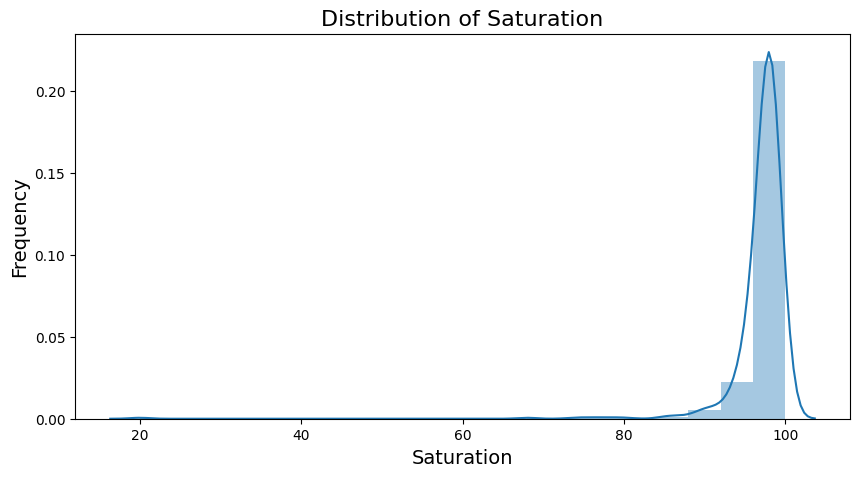

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.distplot(data['Saturation'], bins = 20) 

# Set titles and labels
ax.set_title('Distribution of Saturation', fontsize=16)
ax.set_xlabel('Saturation', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
plt.show()

In [20]:
# Replacing missing values with mean
data["Saturation"]=data["Saturation"].fillna(data["Saturation"].mean())

#### c) Dealing with Other Missing Values

These columns have a small percentage of missing values around 2%. We will fill the missing values with the median for numerical columns and the mode for categorical columns.

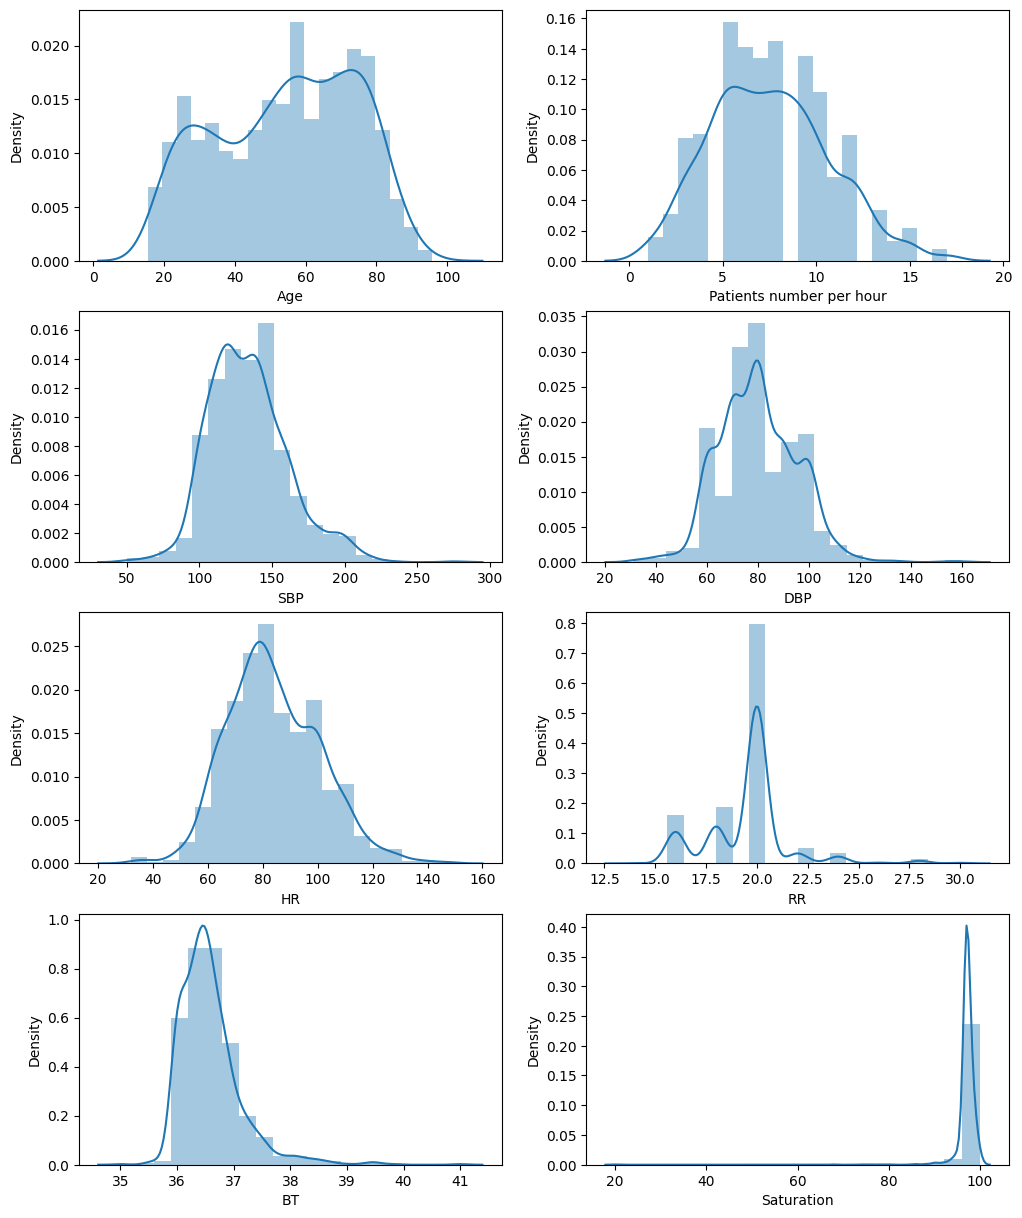

In [21]:
# Histogram and density graphs of all variables were accessed.
fig, ax = plt.subplots(4,2, figsize=(12,15))
sns.distplot(data['Age'], bins = 20, ax=ax[0,0]) 
sns.distplot(data['Patients number per hour'], bins = 20, ax=ax[0,1]) 
sns.distplot(data['SBP'], bins = 20, ax=ax[1,0]) 
sns.distplot(data['DBP'], bins = 20, ax=ax[1,1]) 
sns.distplot(data['HR'], bins = 20, ax=ax[2,0])
sns.distplot(data['RR'], bins = 20, ax=ax[2,1])
sns.distplot(data['BT'], bins = 20, ax=ax[3,0]) 
sns.distplot(data['Saturation'], bins = 20, ax=ax[3,1]) 
plt.show()

In [22]:
#Replacing null values with median
data["SBP"]=data["SBP"].fillna(data["SBP"].median())
data["DBP"]=data["DBP"].fillna(data["DBP"].median())
data["HR"]=data["HR"].fillna(data["HR"].median())
data["RR"]=data["RR"].fillna(data["RR"].median())
data["BT"]=data["BT"].fillna(data["BT"].median())

Since the "Diagnosis in ED" column is categorical, we will replace the two missing entries with the most frequently occurring value.

In [23]:
#Finding the most common diagnosis
data["Diagnosis in ED"].mode()

0    Acute gastroenteritis
Name: Diagnosis in ED, dtype: object

We will replace the null values with "Acute gastroenteritis," as it is the most common entry (mode) in the column.


In [24]:
#Replacing null with mode
data["Diagnosis in ED"]=data["Diagnosis in ED"].fillna('Acute gastroenteritis')

In [25]:
#Checking null values again
data.isna().sum(axis=0)

Group                       0
Gender                      0
Age                         0
Patients number per hour    0
Arrival mode                0
Injury                      0
Chief_complain              0
Mental                      0
Pain                        0
NRS_pain                    0
SBP                         0
DBP                         0
HR                          0
RR                          0
BT                          0
Saturation                  0
KTAS_RN                     0
Diagnosis in ED             0
Disposition                 0
KTAS_expert                 0
Error_group                 0
Length of stay_min          0
KTAS duration_min           0
mistriage                   0
dtype: int64

All null values have been addressed, and our dataset is now ready for EDA.

# 5. Exploratory Data Analysis


## 5.1. Dependent Variable: KTAS Score

In this section, we will analyze the KTAS score as an independent variable. We will examine its distribution, potential correlations with other variables, and its overall impact on patient outcomes in the dataset.

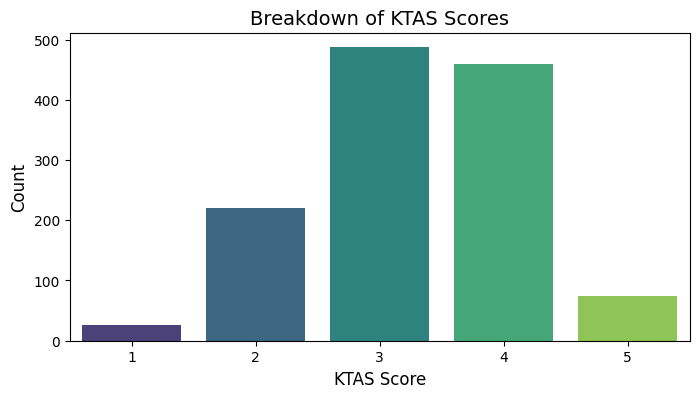

In [26]:
# Create a count plot using seaborn
plt.figure(figsize=(8, 4))
sns.countplot(x='KTAS_expert', data=data, palette='viridis')

# Set the labels and title
plt.xlabel('KTAS Score', size=12)
plt.ylabel('Count', size=12)
plt.title('Breakdown of KTAS Scores', size=14)
plt.show()

#### The dataset is imbalanced across the five classes, with classes 1 and 5 having very few data points, while classes 3 and 4 contain most of the data.<br> To address this, we will group classes 1, 2, and 3 as 'emergency (1)' and classes 4 and 5 as 'non-emergency (0)'.

In [27]:
# Grouping the KTAS classes into emergency (1) and non-emergency (0)
data["KTAS_expert"] = np.where(data["KTAS_expert"] < 4, 1, 0)

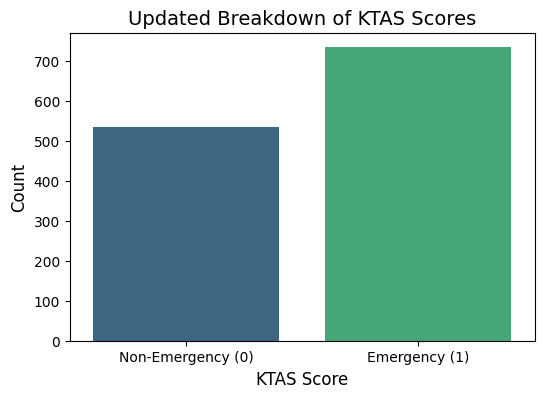

In [28]:
# Count the values in KTAS_expert
ktas_counts = data['KTAS_expert'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=ktas_counts.index, y=ktas_counts.values, palette='viridis')

# Set the labels and title
plt.xlabel('KTAS Score', size=12)
plt.ylabel('Count', size=12)
plt.title('Updated Breakdown of KTAS Scores', size=14)
plt.xticks(ticks=[0, 1], labels=['Non-Emergency (0)', 'Emergency (1)'])  # Customize x-ticks if necessary
plt.show()

The classes of the dependent variable are now more balanced, reducing the likelihood of bias in the model.

## 5.2. Demographic Variables


### a) Gender

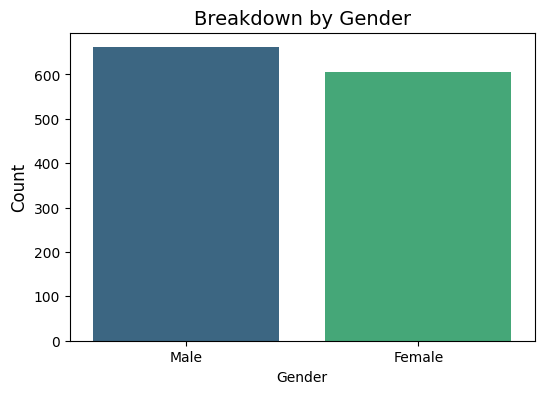

In [29]:
# Plotting Gender
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=data, palette='viridis')

# Set the labels and title
plt.ylabel('Count', size=12)
plt.title('Breakdown by Gender', size=14)
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

- Approximately 55% of ER visitors are male, indicating a higher prevalence of male patients.

### b) Age

In [30]:
# Define age bins and corresponding labels
bins = [-1, 23, 39, 60, float('inf')]  # Use -1 for including ages <= 23 and float('inf') for ages > 60
labels = ['Youth', 'Young Adult', 'Middle-aged Adult', 'Senior']

# Create the age_group column using pd.cut
data['age_group'] = pd.cut(data['Age'], bins=bins, labels=labels)

# Check the result
print(data[['Age', 'age_group']].head())


    Age          age_group
0  71.0             Senior
1  56.0  Middle-aged Adult
2  67.5             Senior
3  71.0             Senior
4  58.0  Middle-aged Adult


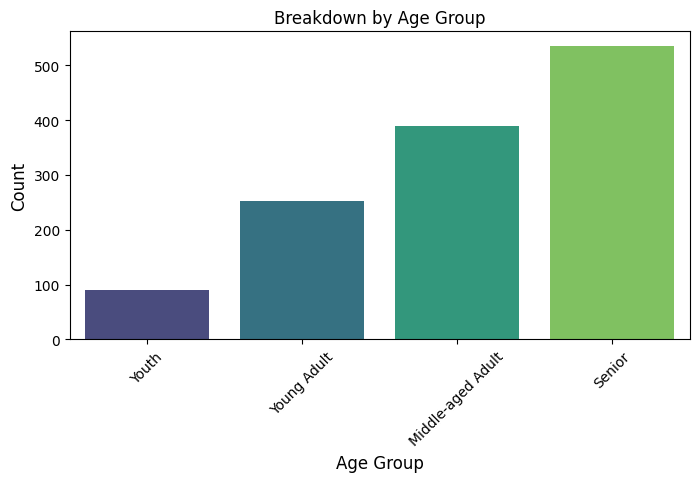

In [31]:
# Plotting the count of each age range using Seaborn with the 'viridis' palette
plt.figure(figsize=(8, 4))
sns.countplot(x='age_group', data=data, palette='viridis')

# Set the labels and title
plt.xlabel('Age Group', size=12)
plt.ylabel('Count', size=12)
plt.title('Breakdown by Age Group')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

- The graph indicates that the "Senior > 60" age group has the highest count, followed by "Middle-aged Adult(40-60)", "Young Adult(24-39", and then "Youth<24"

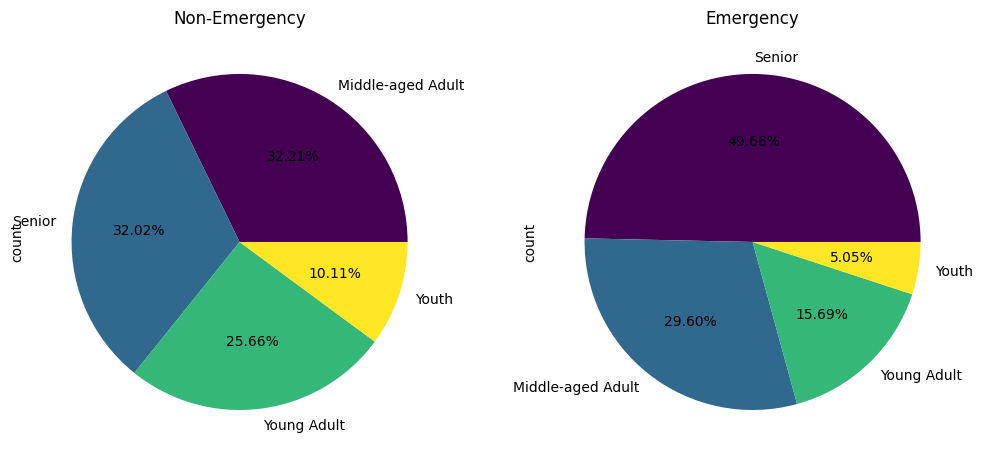

In [32]:
import matplotlib.pyplot as plt

# Plotting the age group vs KTAS score breakdown
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Loop through KTAS expert values and plot
for k, ax in zip([0, 1], axes):
    age_counts = data.loc[data['KTAS_expert'] == k, 'age_group'].value_counts()
    
    colors = plt.get_cmap('viridis', len(age_counts))

    age_counts.plot(
        kind='pie',
        ax=ax,
        autopct='%0.2f%%',
        title='Emergency' if k == 1 else 'Non-Emergency',
        colors=colors(range(len(age_counts))),
        textprops={'color': 'black'},  
    )

plt.tight_layout()
plt.show()


- For emergency patients: Approximately 50% are seniors, and 30% are middle-aged adults.
- For non-emergency patients: Only 31% are seniors, and the majority (likely around 69%) are young adults and middle-aged adults.<br>
This suggests that a higher proportion of seniors and middle-aged adults seek emergency care compared to non-emergency care.<br> It also implies that younger individuals are more likely to present with non-emergency conditions.

## 5.3. Vital Signs

### a) Blood Pressure Measurements


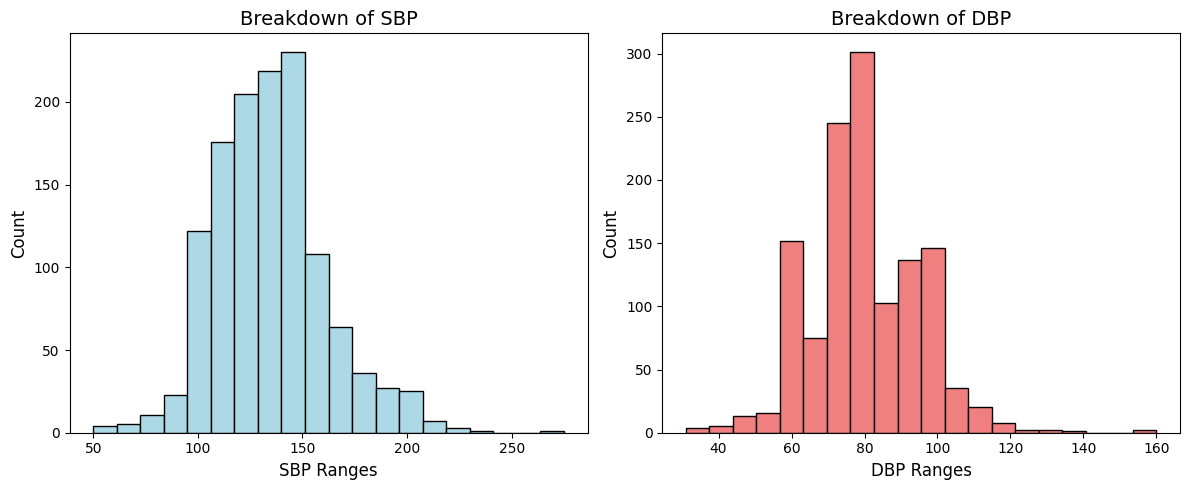

In [33]:
# Create a subplot of two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting SBP histogram
data['SBP'].plot(kind='hist', ax=axs[0], bins=20, color='lightblue', edgecolor='black')
axs[0].set_xlabel('SBP Ranges', size=12)
axs[0].set_ylabel('Count', size=12)
axs[0].set_title('Breakdown of SBP', size=14)

# Plotting DBP histogram
data['DBP'].plot(kind='hist', ax=axs[1], bins=20, color='lightcoral', edgecolor='black')
axs[1].set_ylabel('Count', size=12)
axs[1].set_xlabel('DBP Ranges', size=12)
axs[1].set_title('Breakdown of DBP', size=14)

plt.tight_layout()
plt.show()

### b) Heart Rate and Respiratory Rate

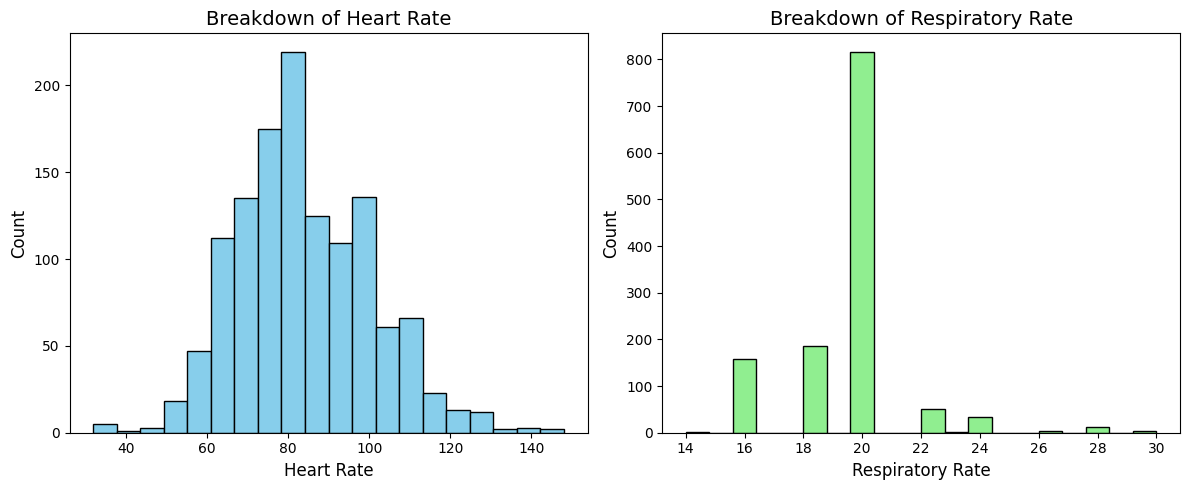

In [34]:
# Create a subplot of two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting HR histogram
data['HR'].plot(kind='hist', ax=axs[0], bins=20, color='skyblue', edgecolor='black')
axs[0].set_xlabel('Heart Rate', size=12)
axs[0].set_ylabel('Count', size=12)
axs[0].set_title('Breakdown of Heart Rate', size=14)

# Plotting RR histogram
data['RR'].plot(kind='hist', ax=axs[1], bins=20, color='lightgreen', edgecolor='black')
axs[1].set_ylabel('Count', size=12)
axs[1].set_xlabel('Respiratory Rate', size=12)
axs[1].set_title('Breakdown of Respiratory Rate', size=14)

plt.tight_layout()
plt.show()

## 5.4. Patient Condition Variables

### a) Pain

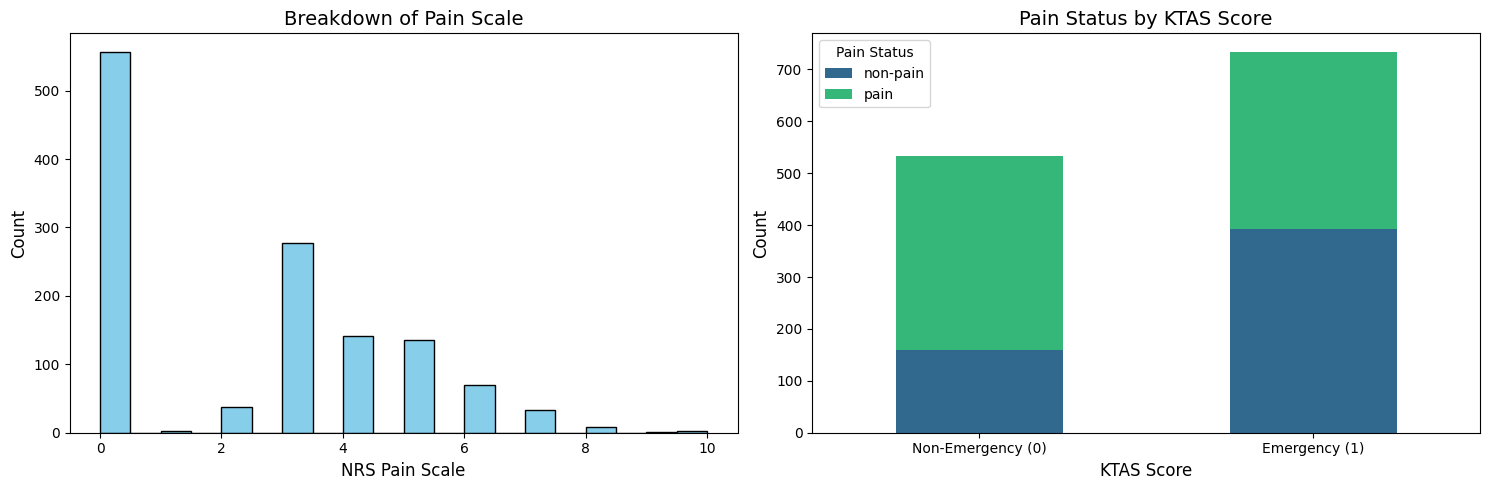

In [35]:
# Create a subplot of two columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotting NRS_pain histogram
data['NRS_pain'].plot(kind='hist', ax=axs[0], bins=20, color='skyblue', edgecolor='black')
axs[0].set_xlabel('NRS Pain Scale', size=12)
axs[0].set_ylabel('Count', size=12)
axs[0].set_title('Breakdown of Pain Scale',size=14)

# Create a DataFrame for the counts of Pain status by KTAS score
pain_status_counts = data.groupby('KTAS_expert')['Pain'].value_counts().unstack()

# Plotting Pain Status
pain_status_counts.plot(kind='bar', stacked=True, color=sns.color_palette('viridis', n_colors=pain_status_counts.shape[1]), ax=axs[1])
axs[1].set_title('Pain Status by KTAS Score', size=14)
axs[1].set_ylabel('Count', size=12)
axs[1].set_xlabel('KTAS Score', size=12)
axs[1].set_xticklabels(['Non-Emergency (0)', 'Emergency (1)'], rotation=0)  # Customize x-ticks
axs[1].legend(title='Pain Status')
plt.tight_layout()
plt.show()

- About half of the ER patients report no pain, while those with pain typically rate it between 2.5 and 5 on a scale of 1 to 10. The histogram resembles a slight normal distribution.

### b) Mental Status

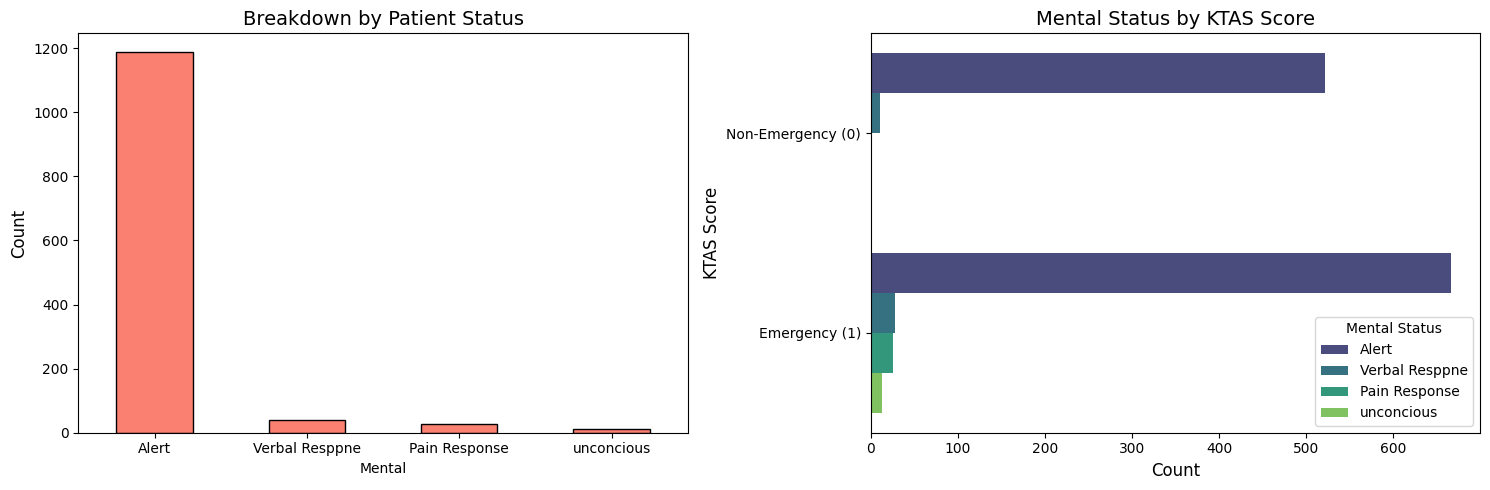

In [36]:
# Create a subplot of three columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Mental state bar chart
data['Mental'].value_counts().plot(kind='bar', ax=axs[0], color='salmon', edgecolor='black')
axs[0].set_ylabel('Count', size=12)
axs[0].set_title('Breakdown by Patient Status',size=14)
axs[0].tick_params(axis='x', rotation=0)  # Keep labels horizontal for clarity

# Plotting Mental Status
sns.countplot(data=data, y='KTAS_expert', hue='Mental', palette='viridis',ax=axs[1])
axs[1].set_title('Mental Status by KTAS Score',size=14)
axs[1].set_xlabel('Count', size=12)
axs[1].set_ylabel('KTAS Score', size=12)
axs[1].legend(title='Mental Status')
axs[1].set_yticks([0, 1])  # Customize y-ticks if necessary
axs[1].set_yticklabels(['Non-Emergency (0)', 'Emergency (1)'])  # Customize y-tick labels
plt.tight_layout()
plt.show()

- Most patients arriving at the ER are alert.


### c) Injury 

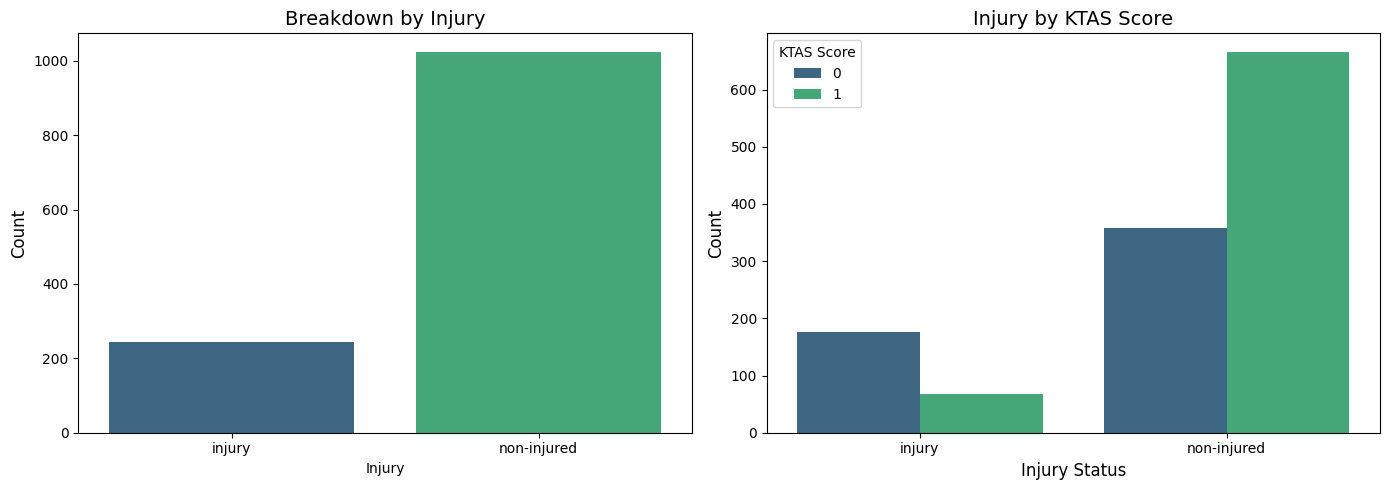

In [37]:
# Create a figure with two subplots in one row
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plotting Injury Count
sns.countplot(x='Injury', data=data, palette='viridis', ax=axs[0])
axs[0].set_ylabel('Count', size=12)
axs[0].set_title('Breakdown by Injury', size=14)
axs[0].tick_params(axis='x', rotation=0)  # Keep injury labels horizontal

# Plotting Injury by KTAS Score
sns.countplot(data=data, x='Injury', hue='KTAS_expert', palette='viridis', ax=axs[1])
axs[1].set_title('Injury by KTAS Score', size=14)
axs[1].set_xlabel('Injury Status', size=12)
axs[1].set_ylabel('Count', size=12)
axs[1].legend(title='KTAS Score')
plt.tight_layout()
plt.show()

- Most patients arriving at the ER do not have an injury, with injured patients comprising only 15% of the total.

## 5.5. Patient Flow Variables

### a) Incoming Patients to ER

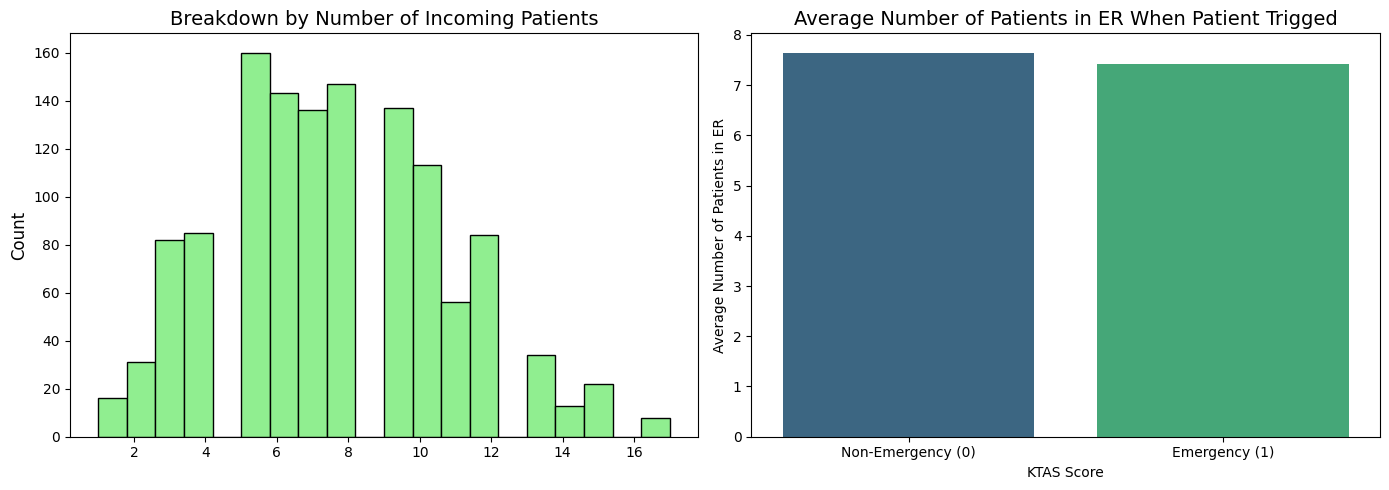

In [38]:
# Create a subplot of two columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))


# Plotting Patients number per hour histogram
data['Patients number per hour'].plot(kind='hist', ax=axs[0], bins=20, color='lightgreen', edgecolor='black')
axs[0].set_ylabel('Count', size=12)
axs[0].set_title('Breakdown by Number of Incoming Patients', size=14)


# Calculate the average number of patients per hour for each KTAS score
average_patients = data.groupby('KTAS_expert')['Patients number per hour'].mean().reset_index()

# Plotting average bumber of patients by class
sns.barplot(data=average_patients, x='KTAS_expert', y='Patients number per hour', palette='viridis',ax=axs[1])
axs[1].set_title('Average Number of Patients in ER When Patient Trigged', size=14)
axs[1].set_ylabel('Average Number of Patients in ER') 
axs[1].set_xlabel('KTAS Score')  
axs[1].set_xticks([0, 1]) 
axs[1].set_xticklabels(['Non-Emergency (0)', 'Emergency (1)'])  
plt.tight_layout()
plt.show()

- The histogram of incoming patient numbers shows a bimodal distribution with two peaks.

### b) Arrival Mode

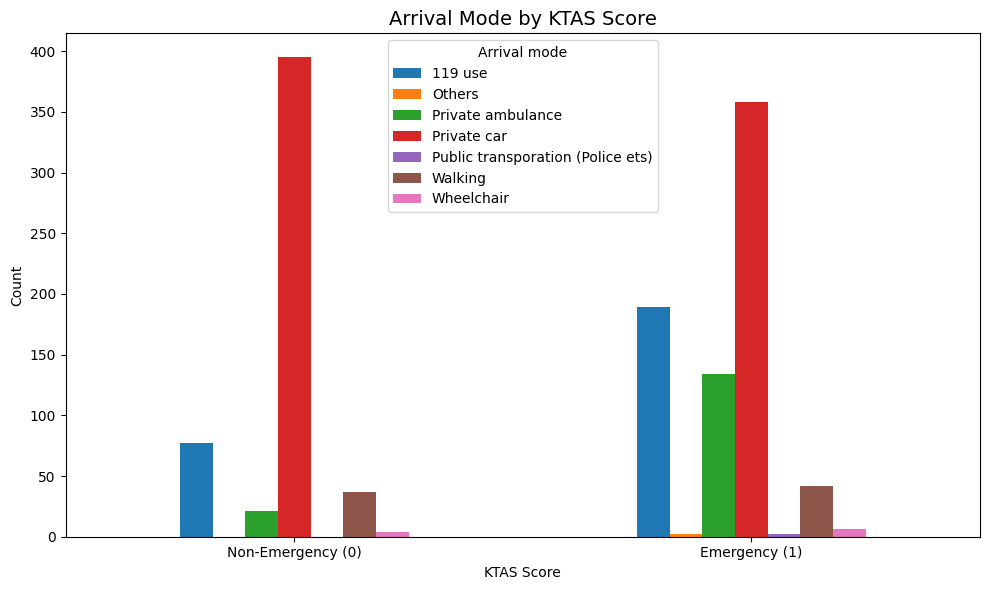

In [39]:
# Grouping by KTAS and counting arrival mode
data.groupby('KTAS_expert')['Arrival mode'].value_counts().unstack().plot(kind='bar', figsize=(10, 6))

plt.title('Arrival Mode by KTAS Score',size=14) 
plt.ylabel('Count')  
plt.xlabel('KTAS Score')  
plt.xticks(rotation=0)  
plt.xticks(ticks=[0, 1], labels=['Non-Emergency (0)', 'Emergency (1)'])  
plt.tight_layout()  
plt.show()

### c) Disposition

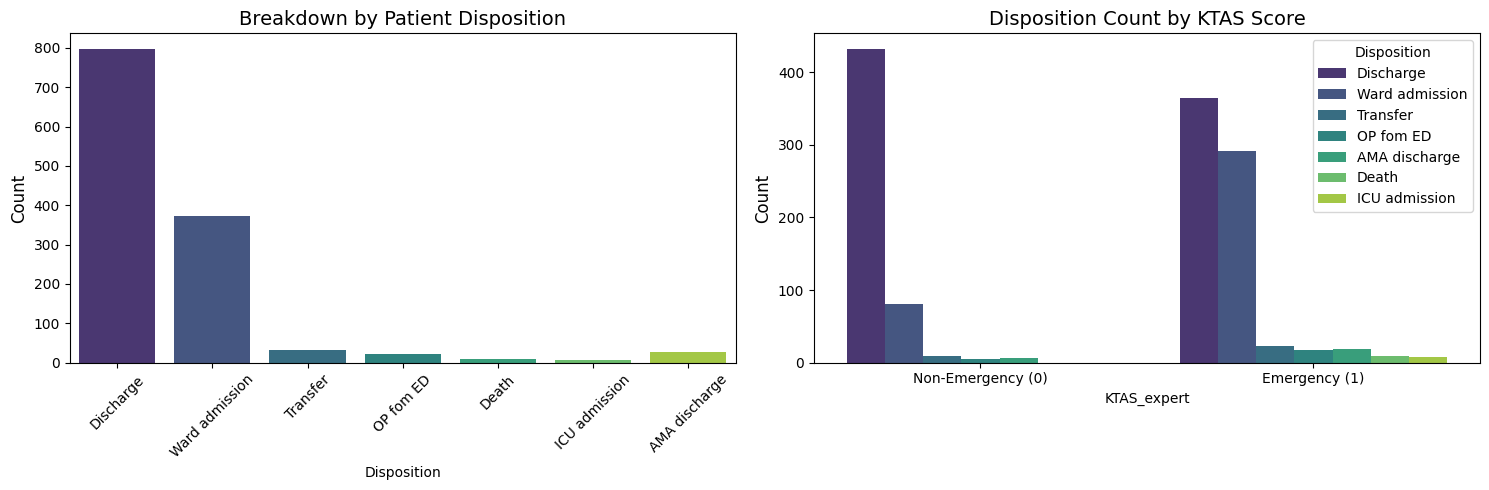

In [40]:
# Create a subplot of two columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Disposition
sns.countplot(x='Disposition', data=data, ax=axs[0], palette='viridis')
axs[0].set_ylabel('Count', size=12)
axs[0].set_title('Breakdown by Patient Disposition', size=14)
axs[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Creating a count plot for disposition by KTAS score
sns.countplot(data=data, x='KTAS_expert', hue='Disposition',ax=axs[1], palette='viridis')
axs[1].set_title('Disposition Count by KTAS Score', size=14)
axs[1].set_ylabel('Count', size=12)
axs[1].set_xticklabels(['Non-Emergency (0)', 'Emergency (1)'], rotation=0)  # Customize x-ticks
plt.tight_layout()
plt.show()

- The majority of patients are discharged, with admissions being the second most common disposition.

## 5.6. Text Analysis
This section focuses on the generation of word clouds, the transformation of textual data into a bag-of-words representation, and the application of logistic regression for predicting emergency status based on patient complaints.

### a) Word Cloud Visualization of Chief Complaints

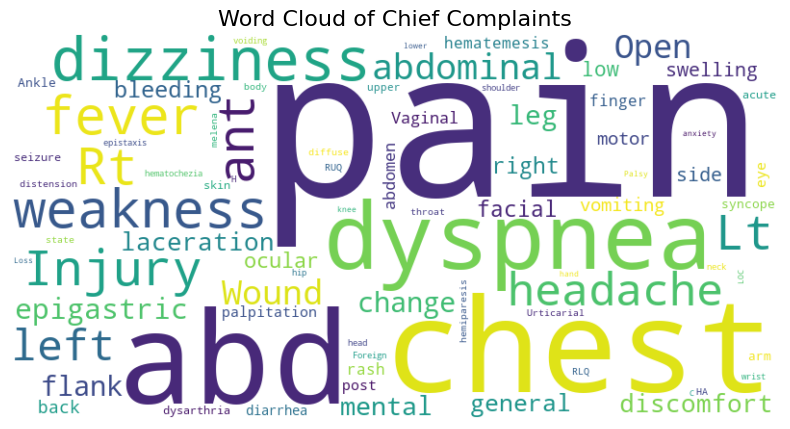

In [41]:

# Generate the word cloud
word_cloud2 = WordCloud(
    collocations=False,        # Do not combine words with common collocations
    background_color='white',  # Set background color to white
    max_words=80,             # Limit the maximum number of words
    width=800,                # Set width of the word cloud image
    height=400                # Set height of the word cloud image
).generate(' '.join(data['Chief_complain'].dropna().astype(str)))  # Joining the complaints into a single string

# Display the word cloud
plt.figure(figsize=(10, 5))  # Set figure size
plt.imshow(word_cloud2, interpolation='bilinear')  # Display the word cloud
plt.axis("off")  # Turn off the axis
plt.title('Word Cloud of Chief Complaints', fontsize=16)  
plt.show()  # Show the plot


### b) Bag-of-Words Transformation of Chief Complaints

In [42]:
# 1. Instantiate CountVectorizer
bagofwords = CountVectorizer(min_df=10, stop_words="english", max_features=500)

# 2. Fit the vectorizer to the 'Chief_complain' column
bagofwords.fit(data['Chief_complain'].dropna())  # Ensure no NaN values disrupt fitting

# 3. Transform the 'Chief_complain' column into a bag-of-words matrix
CF = bagofwords.transform(data['Chief_complain'].dropna())  # Transform the same data without NaN values

# 4. Create a DataFrame of the most common words
df_transformed = pd.DataFrame(
    data=CF.toarray(), 
    columns=bagofwords.get_feature_names_out(), 
    index=data['Chief_complain'].dropna().index  # Ensure the index matches the transformed data
)

# 5. Viewing the created DataFrame
df_transformed.head()  

,abd,abdomen,abdominal,acute,ankle,ant,arm,bleeding,change,chest,...,right,rt,seizure,skin,swelling,syncope,vaginal,vomiting,weakness,wound
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### c) Logistic Regression Model Training
This section outlines fitting a logistic regression model using the transformed bag-of-words data to predict emergency status.

In [43]:
# 1. Fit the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence
logreg.fit(df_transformed, data['KTAS_expert'])

LogisticRegression(max_iter=1000)

### d) Feature Importance Analysis
This section presents the coefficients of the logistic regression model, highlighting the most predictive words for emergency and non-emergency classifications.<br>
It also includes plots that visualize the top and bottom features based on their coefficients, showing words that are most and least predictive of emergency status.

In [44]:
# 2. Create a DataFrame of features and their coefficients
coefficients_df = pd.DataFrame({
    "Feature": df_transformed.columns.tolist(),
    "Coefficients": logreg.coef_[0]
}).sort_values("Coefficients", ascending=False)

# 3. Display the top 3 features with the highest coefficients
print(coefficients_df.head(3))

      Feature  Coefficients
14    dyspnea      2.652192
12  dizziness      2.264698
9       chest      2.165830


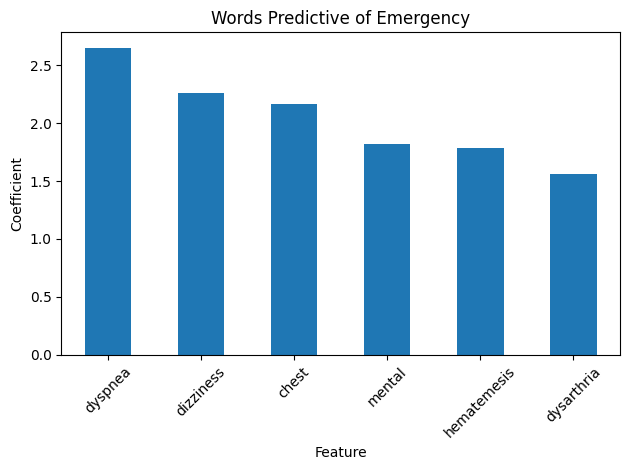

In [45]:
# 4. Plot the top 6 features with the highest coefficients
coefficients_df.head(6).plot(kind='bar', x='Feature', legend=False)
plt.title('Words Predictive of Emergency')
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
# 5. Display the bottom 6 features with the lowest coefficients
print(coefficients_df.tail(6))

       Feature  Coefficients
24      injury     -1.045348
37        rash     -1.065515
4        ankle     -1.305720
27         leg     -1.387796
42    swelling     -1.471253
25  laceration     -2.272539


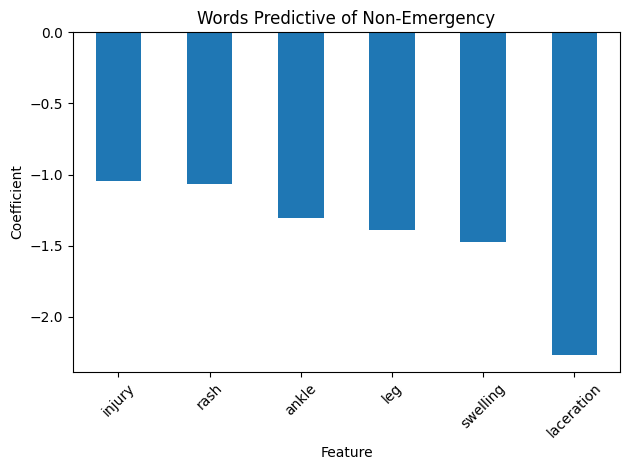

In [47]:
# 6. Plot the top 6 features with the lowest coefficients
coefficients_df.tail(6).plot(kind='bar', x='Feature', legend=False)
plt.title('Words Predictive of Non-Emergency')
plt.ylabel('Coefficient')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Feature Selection and Transformation

## 6.1. Data Preparation

In [48]:
# Dropping irrelevant columns
data.drop(['KTAS_RN', 'Error_group', 'KTAS duration_min', 'mistriage', 
              'Diagnosis in ED', 'Disposition', 'age_group', 'Length of stay_min'], axis=1, inplace=True)

# Converting categorical columns to dummies
data = pd.get_dummies(data, columns=['Group', 'Arrival mode', 'Mental', 'Injury', 'Gender', 'Pain'])

# Selecting and listing the names of columns that have boolean data types
bool_columns = data.select_dtypes(include=[bool]).columns.to_list()
data[bool_columns] = data[bool_columns].astype(int)

# Dropping reference columns
data.drop(['Arrival mode_Others', 'Group_Regional ED', 'Mental_unconcious', 
              'Pain_pain', 'Gender_Male', 'Injury_injury'], axis=1, inplace=True)

# Selecting and listing the names of columns that have numeric data types
num_columns = data.select_dtypes(include=np.number).columns.to_list()

# Check for null values
print(data.isnull().sum())

Age                                               0
Patients number per hour                          0
Chief_complain                                    0
NRS_pain                                          0
SBP                                               0
DBP                                               0
HR                                                0
RR                                                0
BT                                                0
Saturation                                        0
KTAS_expert                                       0
Group_Local ED                                    0
Arrival mode_119 use                              0
Arrival mode_Private ambulance                    0
Arrival mode_Private car                          0
Arrival mode_Public transporation (Police ets)    0
Arrival mode_Walking                              0
Arrival mode_Wheelchair                           0
Mental_Alert                                      0
Mental_Pain 

## 6.2. Correlation Analysis

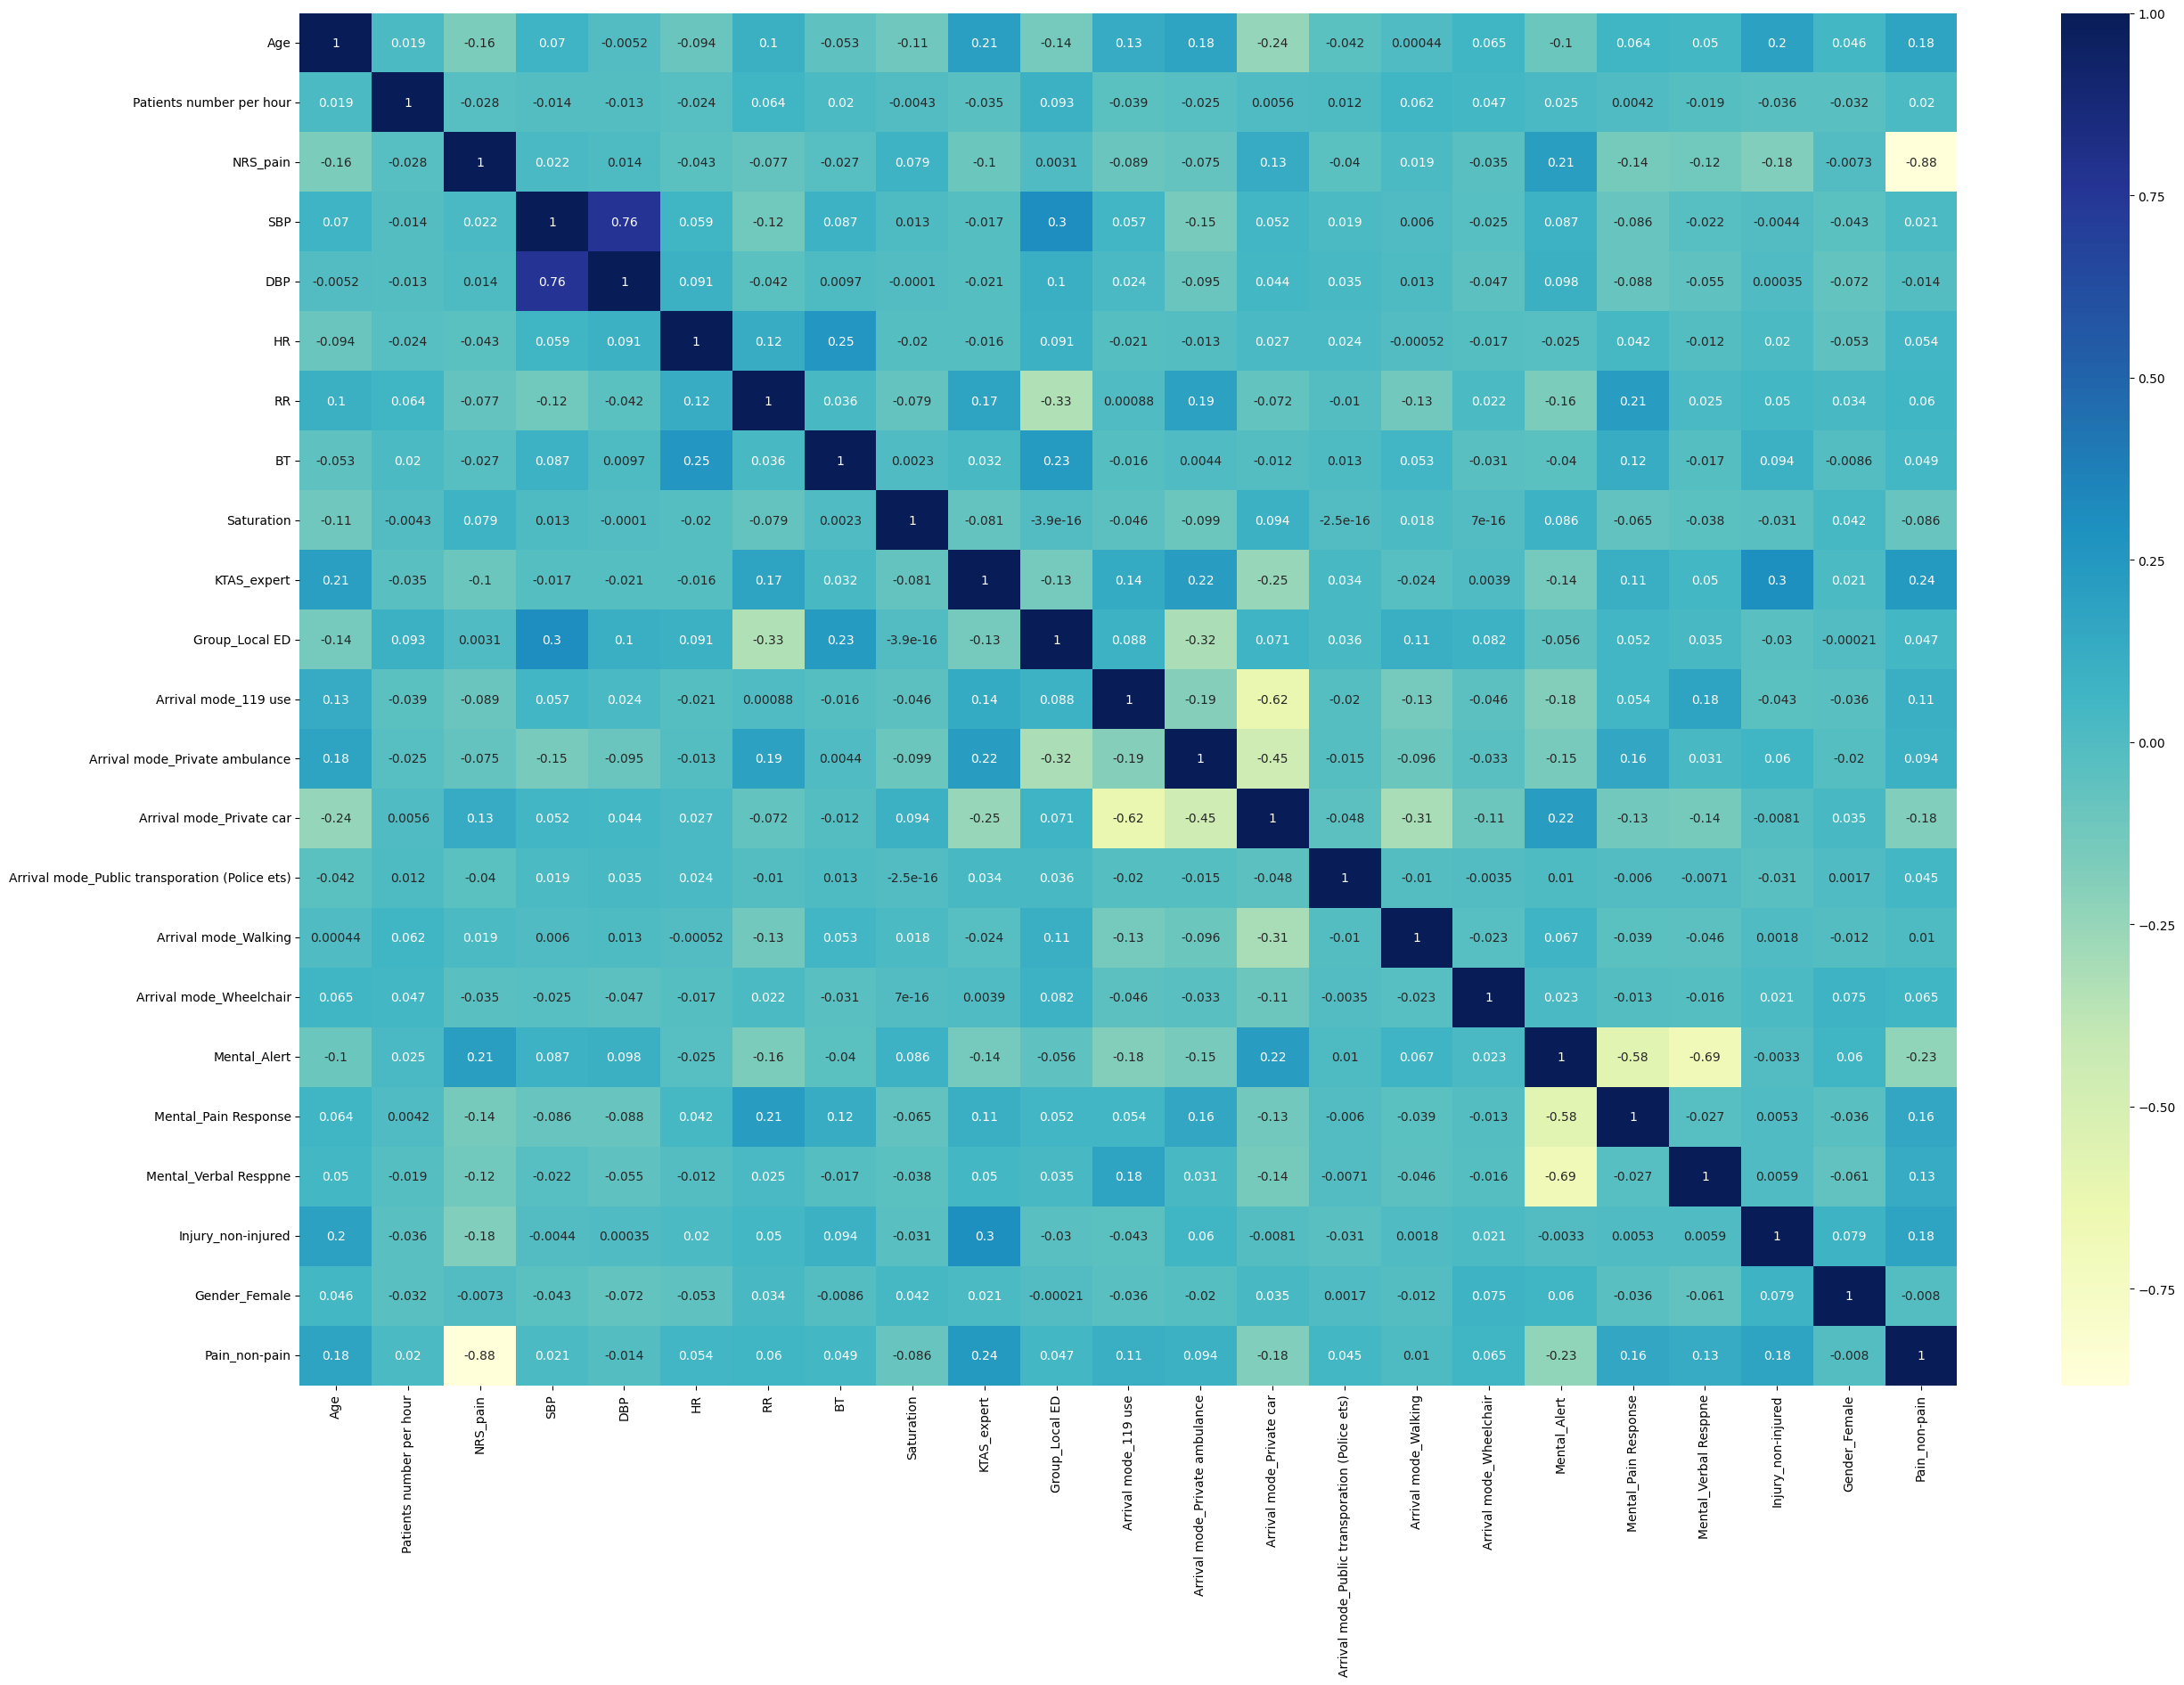

In [49]:
#running a correlation matric
plt.figure(figsize=(30, 20))
sns.heatmap(data[num_columns].corr(), cmap="YlGnBu", annot=True)
plt.show()

In [50]:
# Dropping correlated independent variables
data.drop(['Pain_non-pain', 'SBP'], axis=1, inplace=True)

In [51]:
data.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
Age,1267.0,54.394396,19.722260,15.5,25.0,37.000000,57.000000,71.0,79.0,82.34,88.102,95.8
Patients number per hour,1267.0,7.519337,3.160563,1.0,3.0,5.000000,7.000000,10.0,12.0,13.00,15.000,17.0
NRS_pain,1267.0,2.303078,2.298021,0.0,0.0,0.000000,3.000000,4.0,5.0,6.00,7.340,10.0
DBP,1267.0,79.785320,14.979755,31.0,60.0,70.000000,80.000000,90.0,100.0,102.00,115.000,160.0
HR,1267.0,83.932123,16.513917,32.0,64.0,72.000000,82.000000,96.0,106.0,111.00,127.340,148.0
RR,1267.0,19.515391,2.000089,14.0,16.0,18.000000,20.000000,20.0,20.0,22.00,28.000,30.0
BT,1267.0,36.579479,0.541899,35.0,36.0,36.200000,36.500000,36.8,37.2,37.50,38.534,41.0
Saturation,1267.0,97.024561,2.916648,20.0,97.0,97.024561,97.024561,98.0,99.0,99.00,100.000,100.0
KTAS_expert,1267.0,0.578532,0.493989,0.0,0.0,0.000000,1.000000,1.0,1.0,1.00,1.000,1.0
Group_Local ED,1267.0,0.543015,0.498343,0.0,0.0,0.000000,1.000000,1.0,1.0,1.00,1.000,1.0


### 6.3. Data Scaling and Normalization

In [52]:
# Retrieving numeric columns 
df_num = data[['Age', 'Patients number per hour', 'NRS_pain', 'DBP', 'HR', 'RR', 'BT', 'Saturation']]

# Retrieving categorical columns
df_cat = data.drop(['Age', 'Patients number per hour', 'NRS_pain', 'DBP', 'HR', 
                               'RR', 'BT', 'Saturation', 'KTAS_expert', 'Chief_complain'], axis=1)

In [53]:
# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_num)
df_numeric_scaled = pd.DataFrame(data=scaled_data, columns=df_num.columns)

In [54]:
df_numeric_scaled

,Age,Patients number per hour,NRS_pain,DBP,HR,RR,BT,Saturation
0,0.691158,0.1250,0.2,0.534884,0.448276,0.250,0.266667,1.000000
1,0.504359,0.6875,0.2,0.341085,0.241379,0.375,0.250000,0.962807
2,0.647572,0.4375,0.2,0.379845,0.603448,0.375,0.266667,0.975000
3,0.691158,0.4375,0.3,0.488372,0.482759,0.375,0.250000,0.962807
4,0.529265,0.1875,0.3,0.279070,0.525862,0.250,0.250000,0.962807
...,...,...,...,...,...,...,...,...
1262,0.789539,0.2500,0.0,0.379845,0.465517,0.500,0.233333,0.937500
1263,0.813200,0.0625,0.0,0.379845,0.534483,0.375,0.233333,0.962500
1264,0.814446,1.0000,0.0,0.457364,0.413793,0.375,0.200000,0.987500
1265,0.815691,0.0625,0.0,0.534884,0.396552,0.375,0.266667,0.975000


### 6.4. Feature Selection and Importance Evaluation

In [55]:
# Variance Thresholding
vt = VarianceThreshold(threshold=0.001)
vt.fit(df_numeric_scaled)

VarianceThreshold(threshold=0.001)

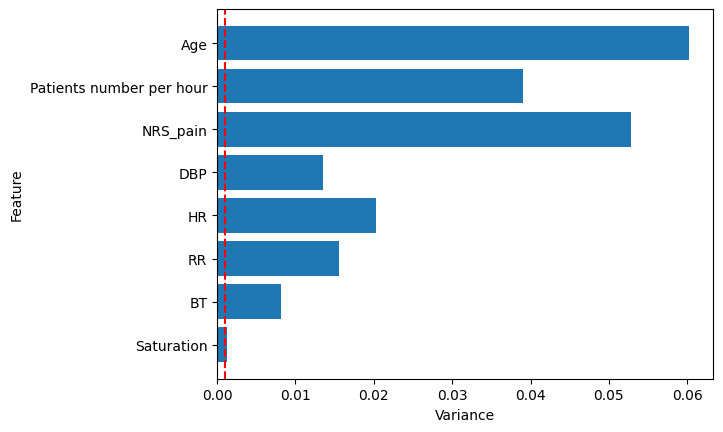

In [56]:
column_variances = vt.variances_

# Plotting the variances
plt.figure()
plt.barh(np.flip(df_numeric_scaled.columns), np.flip(column_variances))
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.axvline(0.001, color='red', linestyle='--')
plt.show()

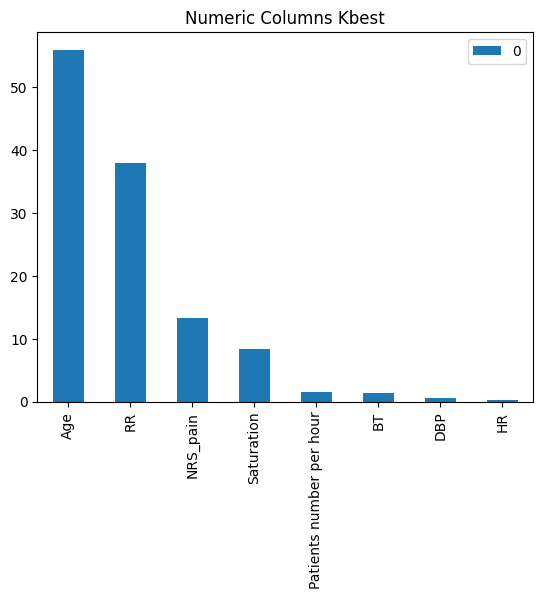

In [57]:
# KBest selection for numeric columns
X = df_numeric_scaled
y = data['KTAS_expert']
my_KBest = SelectKBest(f_classif, k=3).fit(X, y)
df2 = pd.DataFrame(my_KBest.scores_.reshape(-1, len(my_KBest.scores_)), columns=df_numeric_scaled.columns).transpose()
df2.sort_values(by=0, ascending=False).plot(kind='bar', title='Numeric Columns Kbest')
plt.show()

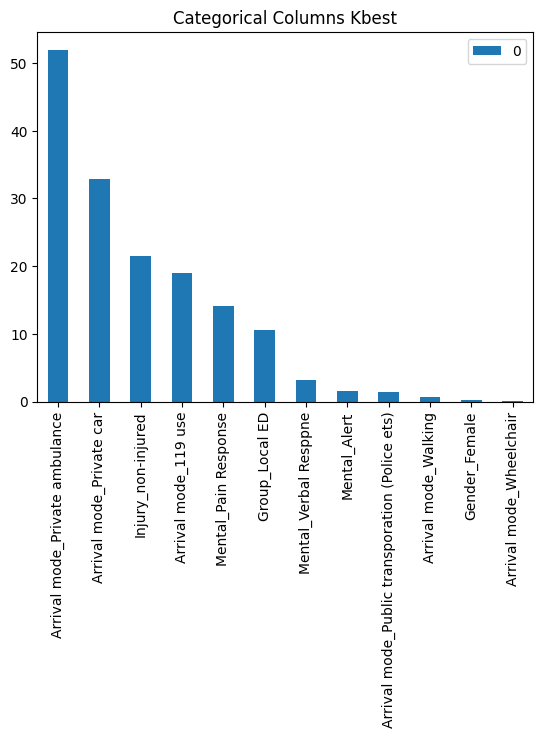

In [58]:
# KBest selection for categorical columns
X = df_cat
y = data['KTAS_expert']
my_KBest_cat = SelectKBest(chi2, k=2).fit(X, y)
df = pd.DataFrame(my_KBest_cat.scores_.reshape(-1, len(my_KBest_cat.scores_)), columns=df_cat.columns).transpose()
df.sort_values(by=0, ascending=False).plot(kind='bar', title='Categorical Columns Kbest')
plt.show()

## 6.5. Final Feature Selection and Text Transformation
This section finalizes the selection of features for modeling by defining the input (X_final) and target (y_final) datasets, splitting the data into training and testing sets, and preparing the text data using CountVectorizer to facilitate analysis. The transformed text data is then combined with the remaining features.

In [59]:
# Finalizing features
X_final = data[['Age', 'Patients number per hour', 'NRS_pain', 'RR', 'Saturation',
                   'Chief_complain', 'Arrival mode_Private ambulance', 
                   'Arrival mode_Private car', 'Injury_non-injured', 
                   'Arrival mode_119 use', 'Mental_Pain Response']]
y_final = data[['KTAS_expert']]



In [60]:
X_final

,Age,Patients number per hour,NRS_pain,RR,Saturation,Chief_complain,Arrival mode_Private ambulance,Arrival mode_Private car,Injury_non-injured,Arrival mode_119 use,Mental_Pain Response
0,71.0,3,2.0,18.0,100.000000,right ocular pain,0,1,0,0,0
1,56.0,12,2.0,20.0,97.024561,right forearm burn,0,1,0,0,0
2,67.5,8,2.0,20.0,98.000000,"arm pain, Lt",0,0,0,1,0
3,71.0,8,3.0,20.0,97.024561,ascites tapping,0,0,1,0,0
4,58.0,4,3.0,18.0,97.024561,"distension, abd",0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1262,78.9,5,0.0,22.0,95.000000,mental change,0,0,1,1,0
1263,80.8,2,0.0,20.0,97.000000,dysuria,0,1,1,0,0
1264,80.9,17,0.0,20.0,99.000000,dizziness,0,0,1,1,0
1265,81.0,2,0.0,20.0,98.000000,"Sensory, Decreased",0,0,0,1,0


In [61]:
# Scaling the data
scaler = MinMaxScaler()
data_scale=X_final.drop(columns=['Chief_complain'])
scaled_data = scaler.fit_transform(data_scale)
df_scaled = pd.DataFrame(data=scaled_data, columns=data_scale.columns)
with open('../Models/KTAS_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
df_scaled

,Age,Patients number per hour,NRS_pain,RR,Saturation,Arrival mode_Private ambulance,Arrival mode_Private car,Injury_non-injured,Arrival mode_119 use,Mental_Pain Response
0,0.691158,0.1250,0.2,0.250,1.000000,0.0,1.0,0.0,0.0,0.0
1,0.504359,0.6875,0.2,0.375,0.962807,0.0,1.0,0.0,0.0,0.0
2,0.647572,0.4375,0.2,0.375,0.975000,0.0,0.0,0.0,1.0,0.0
3,0.691158,0.4375,0.3,0.375,0.962807,0.0,0.0,1.0,0.0,0.0
4,0.529265,0.1875,0.3,0.250,0.962807,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1262,0.789539,0.2500,0.0,0.500,0.937500,0.0,0.0,1.0,1.0,0.0
1263,0.813200,0.0625,0.0,0.375,0.962500,0.0,1.0,1.0,0.0,0.0
1264,0.814446,1.0000,0.0,0.375,0.987500,0.0,0.0,1.0,1.0,0.0
1265,0.815691,0.0625,0.0,0.375,0.975000,0.0,0.0,0.0,1.0,0.0


In [62]:
# Split the dataset
# Instantiate and fit a single CountVectorizer
bagofwords = CountVectorizer(max_features=12)
CF = bagofwords.fit_transform(X_final['Chief_complain'])

with open('../Models/nlp_complain.pkl', 'wb') as file:
    pickle.dump(bagofwords, file)

# Combine transformed text data with remaining features
df_transformed = pd.concat([df_scaled, pd.DataFrame(CF.toarray(), columns=bagofwords.get_feature_names_out(), 
                                index=df_scaled.index)], axis=1)

In [63]:
df_transformed

,Age,Patients number per hour,NRS_pain,RR,Saturation,Arrival mode_Private ambulance,Arrival mode_Private car,Injury_non-injured,Arrival mode_119 use,Mental_Pain Response,...,chest,dizziness,dyspnea,fever,headache,injury,lt,pain,rt,weakness
0,0.691158,0.1250,0.2,0.250,1.000000,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.504359,0.6875,0.2,0.375,0.962807,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.647572,0.4375,0.2,0.375,0.975000,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
3,0.691158,0.4375,0.3,0.375,0.962807,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.529265,0.1875,0.3,0.250,0.962807,0.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,0.789539,0.2500,0.0,0.500,0.937500,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1263,0.813200,0.0625,0.0,0.375,0.962500,0.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1264,0.814446,1.0000,0.0,0.375,0.987500,0.0,0.0,1.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1265,0.815691,0.0625,0.0,0.375,0.975000,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(df_transformed, y_final, test_size=0.2, random_state=42)
df_transformed_train=X_train
df_transformed_test=X_test

# 7. Baseline Model Development
This section establishes a baseline model using logistic regression. The model is trained on the transformed training dataset, and its performance is evaluated by calculating and displaying the accuracy scores for both the training and testing datasets.

Train score: 0.7068
Test score: 0.7205

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.68       108
           1       0.77      0.74      0.75       146

    accuracy                           0.72       254
   macro avg       0.71      0.72      0.72       254
weighted avg       0.72      0.72      0.72       254



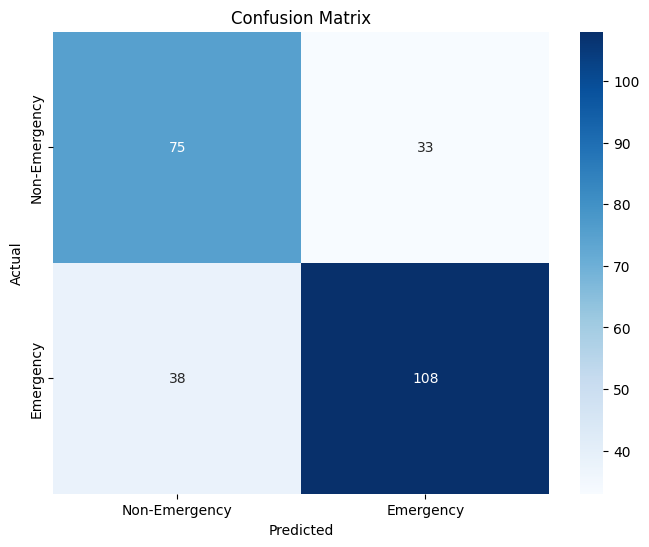

In [65]:
# Instantiate the logistic regression model
logreg = LogisticRegression()
# Fit the model on the transformed training data
logreg.fit(df_transformed_train, y_train)

# Scoring the model against the training and testing data
train_score = logreg.score(df_transformed_train, y_train)
test_score = logreg.score(df_transformed_test, y_test)

# Print the accuracy scores
print(f"Train score: {train_score:.4f}")
print(f"Test score: {test_score:.4f}")

# Making predictions on the test set
y_pred = logreg.predict(df_transformed_test)

print("")
# Evaluating the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
conf_matrix=confusion_matrix(y_test, y_pred)
# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Emergency', 'Emergency'], yticklabels=['Non-Emergency', 'Emergency'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 8. Exploring Additional Models

In [66]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate the model and return a dictionary of performance metrics."""
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics


# List to store all model results
model_results = []

### a) Logistic Regression

Best parameters: {'model__C': 1, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'saga'}
Training score: 0.7107601184600197
Test score: 0.7283464566929134
Recall: 0.636986301369863
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.85      0.73       108
           1       0.85      0.64      0.73       146

    accuracy                           0.73       254
   macro avg       0.74      0.74      0.73       254
weighted avg       0.76      0.73      0.73       254



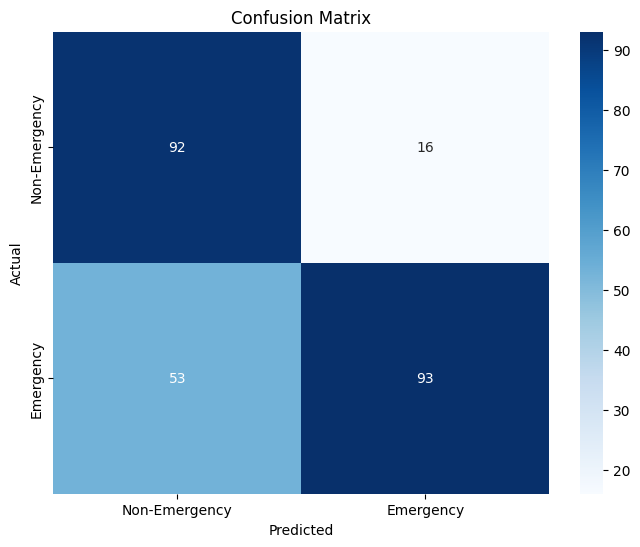

In [67]:
# Create a pipeline for logistic regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Logistic Regression
log_reg_param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['saga', 'lbfgs'],
    'model__class_weight': ['balanced']
}

# Re-run grid search
log_reg_grid = GridSearchCV(pipe, log_reg_param_grid, cv=3)
log_reg_grid.fit(df_transformed_train, y_train)


# Print best parameters
print(f"Best parameters: {log_reg_grid.best_params_}")

# Fit the pipeline using the best hyperparameters
best_log_reg = log_reg_grid.best_estimator_
best_log_reg.fit(df_transformed_train, y_train)

# Print training and test scores
print(f"Training score: {best_log_reg.score(df_transformed_train, y_train)}")
print(f"Test score: {best_log_reg.score(df_transformed_test, y_test)}")

# Predict and calculate recall on the test set
y_pred = best_log_reg.predict(df_transformed_test)
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")


log_metrics = evaluate_model(y_test, y_pred, 'Logistic Regression')
model_results.append(log_metrics)
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Emergency', 'Emergency'], 
            yticklabels=['Non-Emergency', 'Emergency'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### b) Decision Tree

Best parameters: {'model__class_weight': None, 'model__max_depth': 6, 'model__min_samples_leaf': 10}
Test score: 0.7637795275590551
Recall: 0.8698630136986302

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       108
           1       0.76      0.87      0.81       146

    accuracy                           0.76       254
   macro avg       0.77      0.75      0.75       254
weighted avg       0.77      0.76      0.76       254



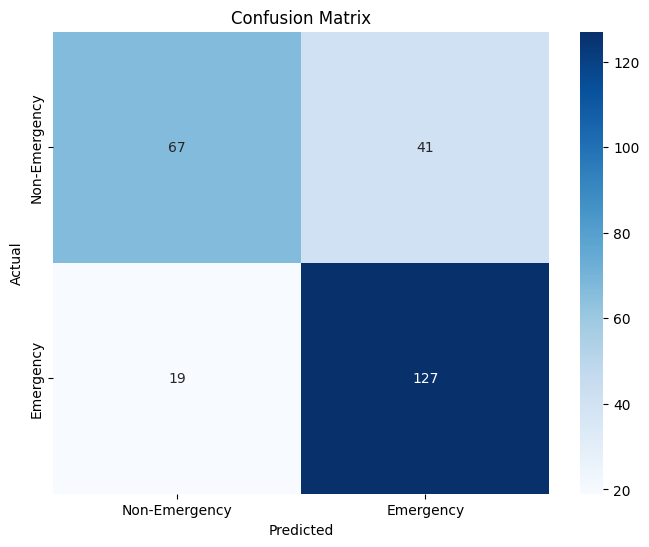

In [68]:


# Define a simplified pipeline for the Decision Tree (no need for StandardScaler)
pipe_dt = Pipeline([
    ('model', DecisionTreeClassifier())
])

# Define the hyperparameter grid for grid search
param_grid = {
    'model__max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 20],  # Max depth of the tree
    'model__min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16, 20],  # Minimum samples per leaf
    'model__class_weight': ['balanced', None]  # To handle class imbalance
}

# Running a grid search to find the best hyperparameters
dt_param_grid = GridSearchCV(pipe_dt, param_grid, cv=5)
dt_param_grid.fit(df_transformed_train, y_train)

# Displaying the best parameters
print(f"Best parameters: {dt_param_grid.best_params_}")

# Fit the model using the best parameters found in the grid search
best_dt = dt_param_grid.best_estimator_
best_dt.fit(df_transformed_train, y_train)

# Print test score
print(f'Test score: {best_dt.score(df_transformed_test, y_test)}')

# Predicting on test data
y_pred_tree = best_dt.predict(df_transformed_test)

# Calculate recall
recall = recall_score(y_test, y_pred_tree)
print(f'Recall: {recall}')

# Decision Tree Evaluation
tree_metrics = evaluate_model(y_test, y_pred_tree, 'Decision Tree')
model_results.append(tree_metrics)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Emergency', 'Emergency'], yticklabels=['Non-Emergency', 'Emergency'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### c) k-nearest neighbors 

Best parameters: {'model__algorithm': 'ball_tree', 'model__n_neighbors': 14, 'model__weights': 'distance'}
Test score: 0.7362204724409449

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       108
           1       0.78      0.76      0.77       146

    accuracy                           0.74       254
   macro avg       0.73      0.73      0.73       254
weighted avg       0.74      0.74      0.74       254



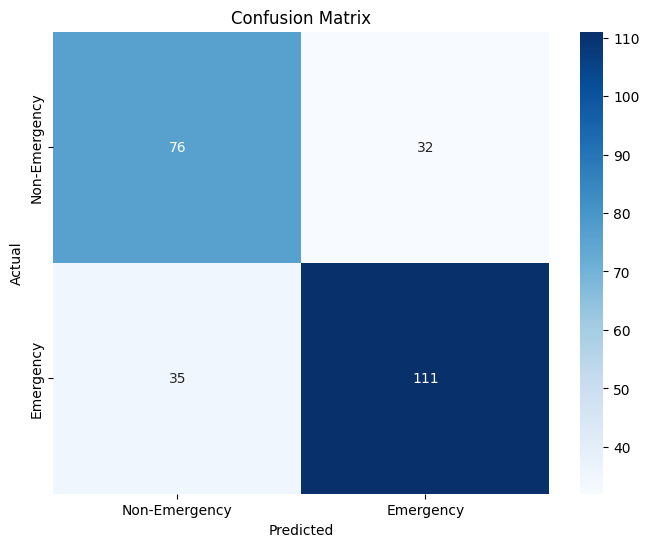

In [69]:

# Creating a pipeline to run the KNN model with scaling
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),  # Always scaling the data for KNN
    ('model', KNeighborsClassifier())  # KNN model
])

# Define the hyperparameter grid for grid search
knn_param_grid= {
    'model__n_neighbors': range(2, 51, 2),  # Number of neighbors (step by 2 for efficiency)
    'model__weights': ['uniform', 'distance'],  # Weight function options
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute nearest neighbors
}

# Running a grid search to find the best hyperparameters
knn_grid = GridSearchCV(pipe_knn, knn_param_grid, cv=5)
knn_grid.fit(df_transformed_train, y_train)

# Displaying the best parameters
print(f"Best parameters: {knn_grid.best_params_}")

# Using the best parameters to create a new pipeline
best_knn_model = knn_grid.best_estimator_

# Fit the best model with the training data
best_knn_model.fit(df_transformed_train, y_train)

# Print test score
test_score = best_knn_model.score(df_transformed_test, y_test)
print(f'Test score: {test_score}')

# Predicting on test data
y_pred_knn = best_knn_model.predict(df_transformed_test)

# KNN Evaluation
knn_metrics = evaluate_model(y_test, y_pred_knn, 'K-Nearest Neighbors')
model_results.append(knn_metrics)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Emergency', 'Emergency'], yticklabels=['Non-Emergency', 'Emergency'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### d) Support Vector Machines

Best parameters for SVM: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Test score for SVM: 0.7834645669291339

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       108
           1       0.82      0.80      0.81       146

    accuracy                           0.78       254
   macro avg       0.78      0.78      0.78       254
weighted avg       0.78      0.78      0.78       254



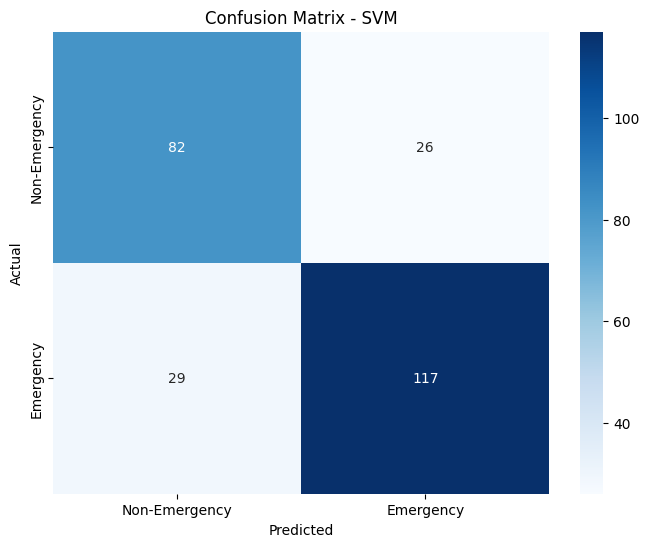

In [70]:
# Creating a pipeline to run the SVM model with scaling
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),  
    ('model', SVC())  
])

# Define the hyperparameter grid for grid search
svm_param_grid = {
    'model__C': [0.1, 1, 10, 100],  # Regularization parameter
    'model__kernel': ['linear', 'rbf'],  # Kernel type
    'model__gamma': ['scale', 'auto']  # Kernel coefficient
}

# Running a grid search to find the best hyperparameters
svm_grid = GridSearchCV(pipe_svm, svm_param_grid, cv=5)
svm_grid.fit(df_transformed_train, y_train)

# Displaying the best parameters
print(f"Best parameters for SVM: {svm_grid.best_params_}")

# Using the best parameters to create a new pipeline
best_svm_model = svm_grid.best_estimator_

# Fit the best model with the training data
best_svm_model.fit(df_transformed_train, y_train)

# Print test score
test_score_svm = best_svm_model.score(df_transformed_test, y_test)
print(f'Test score for SVM: {test_score_svm}')

# Predicting on test data
y_pred_svm = best_svm_model.predict(df_transformed_test)

# SVM Evaluation
svm_metrics = evaluate_model(y_test, y_pred_svm, 'Support Vector Machine')
model_results.append(svm_metrics)

# Print classification report and confusion matrix
print("\nClassification Report for SVM:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix Visualization
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Emergency', 'Emergency'], 
            yticklabels=['Non-Emergency', 'Emergency'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

### d) Gradient Boosting Classifier

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best score: 0.7798322196751695
Best parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Test score: 0.7913385826771654

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       108
           1       0.78      0.89      0.83       146

    accuracy                           0.79       254
   macro avg       0.80      0.77      0.78       254
weighted avg       0.79      0.79      0.79       254



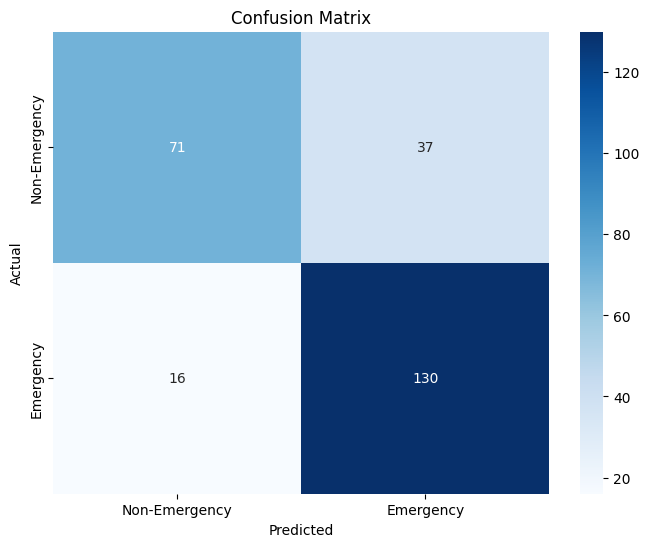

In [71]:
# Creating the Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

# Selecting range of parameters for grid search
parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.001, 0.1, 1, 10],
    'n_estimators': [100, 150, 180, 200]
}

# Running grid search to find the best parameters
grid_search_gbc = GridSearchCV(gbc, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search_gbc.fit(df_transformed_train, np.ravel(y_train))

# Best score and parameters
print(f"Best score: {grid_search_gbc.best_score_}")
print(f"Best parameters: {grid_search_gbc.best_params_}")

# Using the best estimator from grid search
best_gbc = grid_search_gbc.best_estimator_

# Printing test score using the best GBC model
test_score = best_gbc.score(df_transformed_test, y_test)
print(f'Test score: {test_score}')


# Gradient Boosting Classifier Evaluation
y_pred_gbc = best_gbc.predict(df_transformed_test)
gbc_metrics = evaluate_model(y_test, y_pred_gbc, 'Gradient Boosting Classifier')
model_results.append(gbc_metrics)

# Printing classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gbc))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_gbc)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Emergency', 'Emergency'], yticklabels=['Non-Emergency', 'Emergency'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### e) Random Forest Classifier

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best score: 0.79761010583817
Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Test score: 0.7874015748031497

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       108
           1       0.78      0.88      0.83       146

    accuracy                           0.79       254
   macro avg       0.79      0.77      0.78       254
weighted avg       0.79      0.79      0.78       254



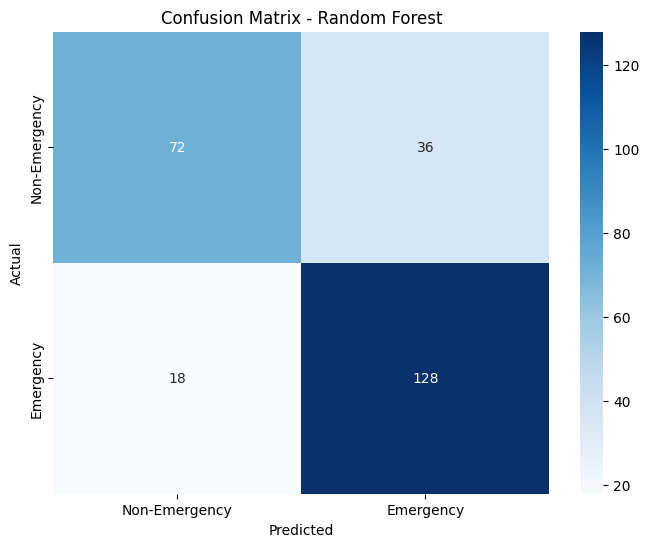

In [72]:

# Creating the Random Forest Classifier
rf = RandomForestClassifier()

# Defining the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Running grid search to find the best parameters
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(df_transformed_train, np.ravel(y_train))

# Best score and parameters
print(f"Best score: {grid_search_rf.best_score_}")
print(f"Best parameters: {grid_search_rf.best_params_}")

# Using the best estimator from grid search
best_rf = grid_search_rf.best_estimator_

# Printing test score using the best Random Forest model
test_score = best_rf.score(df_transformed_test, y_test)
print(f'Test score: {test_score}')

# Predicting on test data
y_pred_rf = best_rf.predict(df_transformed_test)

# Random Forest Evaluation
rf_metrics = evaluate_model(y_test, y_pred_rf, 'Random Forest')
model_results.append(rf_metrics)


# Printing classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Emergency', 'Emergency'], yticklabels=['Non-Emergency', 'Emergency'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [73]:
# Define a function to plot and print feature importances
def plot_and_print_model_var_imp(model, features):
    imp = pd.DataFrame(
        model.feature_importances_,
        columns=['Importance'],
        index=features
    )
    imp = imp.sort_values(by='Importance', ascending=False)

    # Plot the feature importances as a bar chart
    imp.plot(kind='barh', figsize=(12, 6))
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for Random Forest Regressor')
    plt.show()

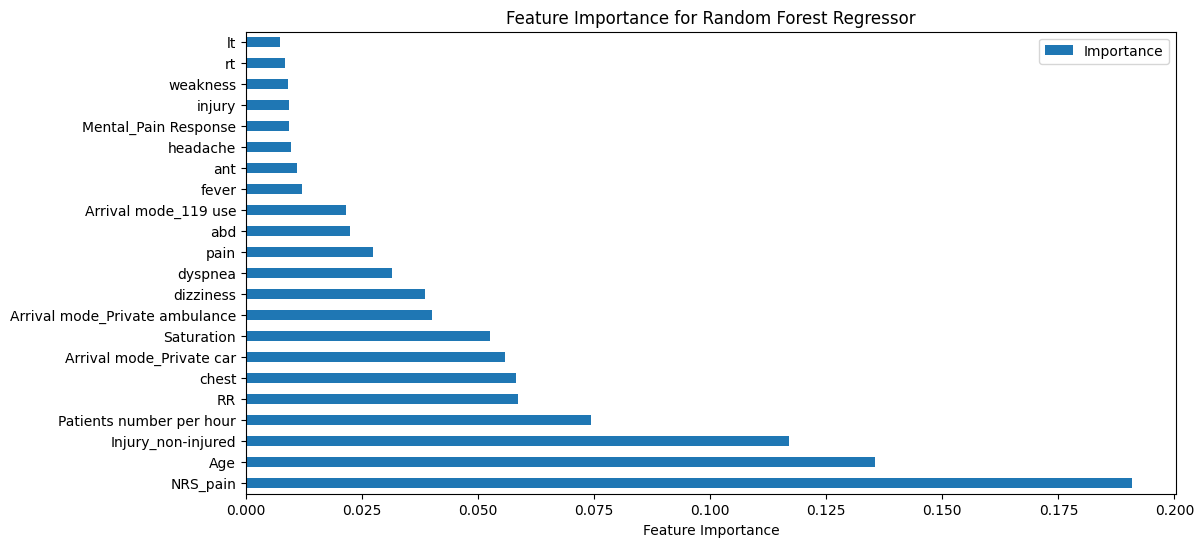

In [74]:
# Call the function to plot and print feature importances
plot_and_print_model_var_imp(best_rf, df_transformed_train.columns)

# 9. Models Evaluation and Selection

## 9.1. Comparison of Model Performance

In [75]:
# Convert list of results to DataFrame
results_df = pd.DataFrame(model_results)

# Display the DataFrame
print(results_df)


                          model  accuracy  precision    recall        f1
0           Logistic Regression  0.728346   0.760208  0.728346  0.728502
1                 Decision Tree  0.763780   0.765782  0.763780  0.758661
2           K-Nearest Neighbors  0.736220   0.737302  0.736220  0.736658
3        Support Vector Machine  0.783465   0.784403  0.783465  0.783824
4  Gradient Boosting Classifier  0.791339   0.794451  0.791339  0.787103
5                 Random Forest  0.787402   0.788784  0.787402  0.783910


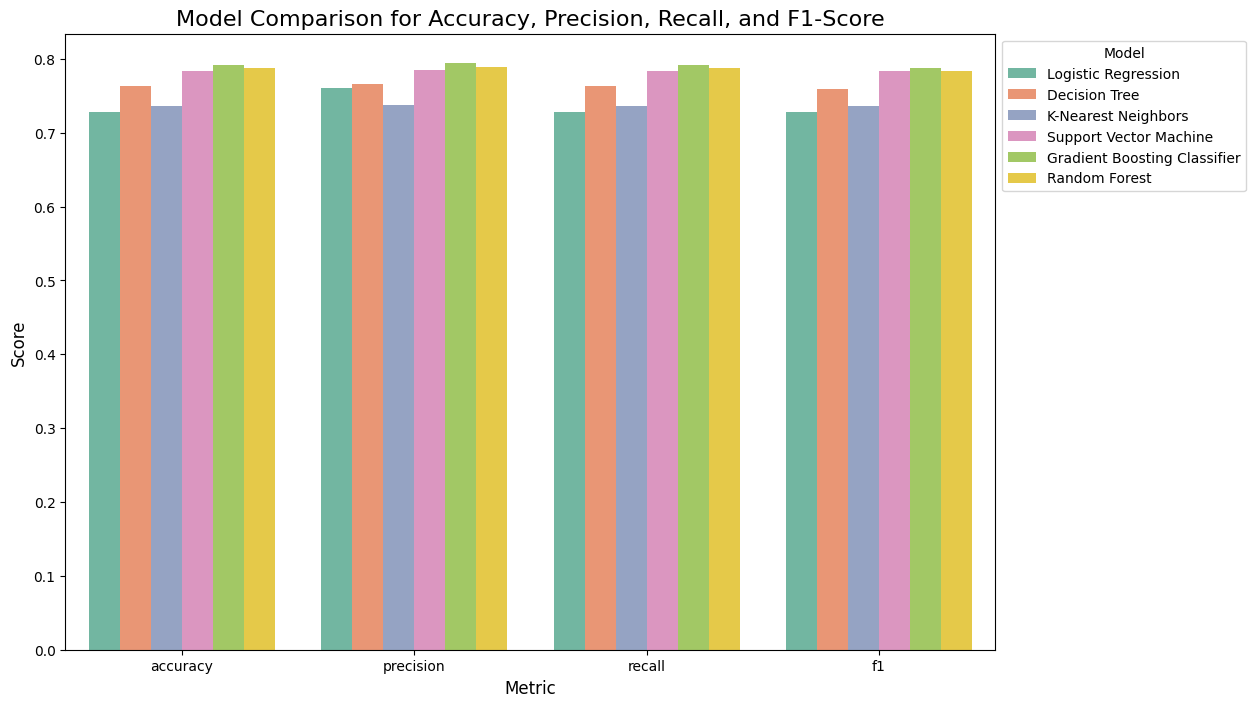

In [76]:
# Reshape the DataFrame to a long format
results_long = pd.melt(results_df, id_vars=['model'], value_vars=['accuracy', 'precision', 'recall', 'f1'],
                       var_name='metric', value_name='value')

# Create a barplot for all metrics in one figure
plt.figure(figsize=(12, 8))
sns.barplot(x='metric', y='value', hue='model', data=results_long, palette='Set2')

# Add titles and labels
plt.title('Model Comparison for Accuracy, Precision, Recall, and F1-Score', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Display the plot
plt.show()


## 9.2. Stacking Classifier Implementation 

Accuracy: 0.7913385826771654

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       108
           1       0.78      0.88      0.83       146

    accuracy                           0.79       254
   macro avg       0.80      0.78      0.78       254
weighted avg       0.79      0.79      0.79       254



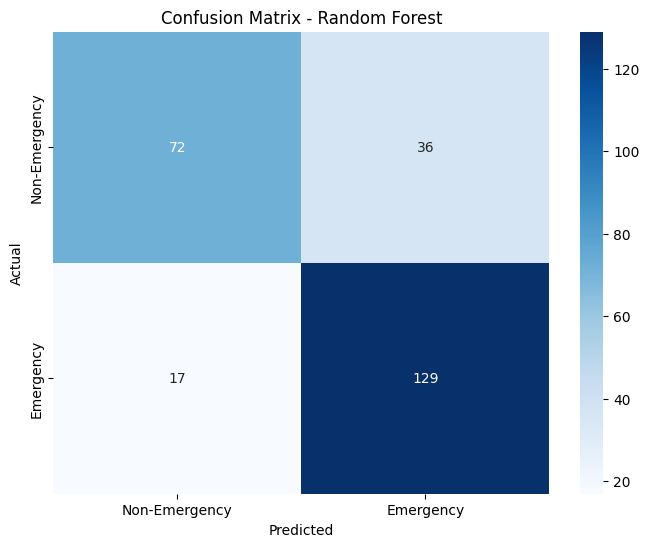

In [77]:
# Create a stacking classifier
stacking_model = StackingClassifier(
    estimators=[('rf', best_rf), ('gbc', best_gbc)],
    final_estimator=LogisticRegression()  # You can choose any model as the final estimator
)

# Fit the stacking model on the training data
stacking_model.fit(df_transformed_train, y_train)

# Predict on the test data
y_pred_stacking = stacking_model.predict(df_transformed_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_stacking))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stacking))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Emergency', 'Emergency'], yticklabels=['Non-Emergency', 'Emergency'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [78]:
# Perform cross-validation
cv_scores = cross_val_score(stacking_model, df_transformed_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())


Cross-validation scores: [0.81773399 0.80295567 0.75369458 0.75742574 0.80693069]
Mean CV score: 0.7877481344193533


In [79]:
# Save the stacking model
with open('../Models/KTAS_model.pkl', 'wb') as file:
    pickle.dump(stacking_model, file)

# 10. Making New Predictions

In [80]:

def make_prediction(age, No_Patients_in_ER, RR, Saturation, NRS_pain, mode_of_transport, Chief_complain, injury, Mental_state):
    """
    Predicts whether a patient is an emergency or non-emergency case based on given features.

    Args:
        age (int): Patient's age.
        No_Patients_in_ER (int): Number of patients in the ER.
        RR (float): Respiratory rate.
        Saturation (float): Oxygen saturation.
        NRS_pain (int): Numerical rating scale for pain.
        mode_of_transport (str): Mode of transportation (e.g., 'car', 'Private ambulance', '119_use').
        Chief_complain (str): Chief complaint of the patient.
        injury (str): Whether the patient has an injury ('yes' or 'no').
        Mental_state (str): Mental state of the patient ('pain_response' or 'Normal').

    Returns:
        str: Prediction of whether the patient is an emergency or non-emergency case.
    """

    # Create DataFrame with input data
    data = {
        "Age": age,
        "RR": RR,
        "Saturation": Saturation,
        'Patients number per hour': No_Patients_in_ER,
        'NRS_pain': NRS_pain,
        'Arrival mode_Private ambulance': mode_of_transport,
        'Injury_non-injured': injury,
        'Chief_complain': Chief_complain,
        'Mental_Pain Response': Mental_state
    }

    # Create DataFrame from input data
    df_new = pd.DataFrame(data, index=[0])

    # Add missing columns with default values
    for col in ['Arrival mode_Private car', 'Arrival mode_119 use']:
        df_new[col] = 0

    # Split DataFrame into numeric, categorical, and text columns
    df_new_numeric = df_new[['Age', 'Patients number per hour', 'NRS_pain','RR', 'Saturation']]

    df_new_categoric = df_new[['Arrival mode_Private ambulance', 'Arrival mode_Private car','Injury_non-injured','Arrival mode_119 use', 'Mental_Pain Response']]
    df_new1 = pd.concat([df_new_numeric, df_new_categoric], axis=1)

        # Convert categorical columns to dummy variables using replace method
    df_new1["Injury_non-injured"] = df_new1["Injury_non-injured"].replace({'no': 0, 'yes': 1})
    df_new1["Mental_Pain Response"] = df_new1["Mental_Pain Response"].replace({'pain_response': 1, 'Normal': 0})
    df_new1["Arrival mode_Private ambulance"] = df_new1["Arrival mode_Private ambulance"].replace({'Private ambulance': 1, 'car': 0, '119_use': 0})
    df_new1["Arrival mode_Private car"] = df_new1["Arrival mode_Private car"].replace({'car': 1, 'Private ambulance': 0, '119_use': 0})
    df_new1["Arrival mode_119 use"] = df_new1["Arrival mode_119 use"].replace({'119_use': 1, 'car': 0, 'Private ambulance': 0})


    with open('../Models/KTAS_scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    df_scaled=scaler.transform(df_new1)

    df_new1 = pd.DataFrame(data=df_scaled, columns=df_new1.columns)

    df_new_text = df_new['Chief_complain']

    # Transform text column using CountVectorizer
    CF4 = bagofwords.transform(df_new['Chief_complain'])
    df_new_comp = pd.DataFrame(columns=bagofwords.get_feature_names_out(), data=CF4.toarray(), index=df_new.index)
    df_new = pd.concat([df_new1, df_new_comp], axis=1)


    # Match order of training set
    final = df_new[['Age', 'Patients number per hour', 'NRS_pain', 'RR', 'Saturation', 'Arrival mode_Private ambulance', 'Arrival mode_Private car', 'Injury_non-injured', 'Arrival mode_119 use', 'Mental_Pain Response', 'abd', 'ant', 'chest', 'dizziness', 'dyspnea', 'fever', 'headache', 'injury', 'lt', 'pain', 'rt', 'weakness']]

    # Make prediction
    prediction = stacking_model.predict(final)
    print(prediction)
    # Print the prediction
    if prediction[0] == 1:
        print('\033[91m THIS PATIENT IS EMERGENCY!!!')
    else:
        print('\033[92m THIS PATIENT IS NON-EMERGENCY')


In [81]:
make_prediction(73, 3, 18.0, 97.00, 3.0, 'Private ambulance', 'injury', 'yes', 'pain_response')

[1]
 THIS PATIENT IS EMERGENCY!!!


In [82]:
#lets run our function with new inputs 
make_prediction(41,5,20.0,98.00,3.0,'119_use','chest pain','no','Normal')

[1]
 THIS PATIENT IS EMERGENCY!!!


In [83]:
#lets run our function with new inputs 
make_prediction(30,8,20.0,97.00,0.0,'car','elbow pain','no','Normal')

[0]
 THIS PATIENT IS NON-EMERGENCY


In [84]:


# Assuming 'stacking_model' and 'bagofwords' are already defined in your environment.

def make_prediction(age, No_Patients_in_ER, RR, Saturation, NRS_pain, mode_of_transport, Chief_complain, injury, Mental_state):
    """
    Predicts whether a patient is an emergency or non-emergency case based on given features.

    Args:
        age (int): Patient's age.
        No_Patients_in_ER (int): Number of patients in the ER.
        RR (float): Respiratory rate.
        Saturation (float): Oxygen saturation.
        NRS_pain (int): Numerical rating scale for pain.
        mode_of_transport (str): Mode of transportation (e.g., 'car', 'Private ambulance', '119_use').
        Chief_complain (str): Chief complaint of the patient.
        injury (str): Whether the patient has an injury ('yes' or 'no').
        Mental_state (str): Mental state of the patient ('pain_response' or 'Normal').

    Returns:
        str: Prediction of whether the patient is an emergency or non-emergency case.
    """

    # Create DataFrame with input data
    data = {
        "Age": age,
        "RR": RR,
        "Saturation": Saturation,
        'Patients number per hour': No_Patients_in_ER,
        'NRS_pain': NRS_pain,
        'Arrival mode_Private ambulance': mode_of_transport,
        'Injury_non-injured': injury,
        'Chief_complain': Chief_complain,
        'Mental_Pain Response': Mental_state
    }

    # Create DataFrame from input data
    df_new = pd.DataFrame(data, index=[0])

    # Add missing columns with default values
    for col in ['Arrival mode_Private car', 'Arrival mode_119 use']:
        df_new[col] = 0

    # Split DataFrame into numeric, categorical, and text columns
    df_new_numeric = df_new[['Age', 'Patients number per hour', 'NRS_pain','RR', 'Saturation']]

    df_new_categoric = df_new[['Arrival mode_Private ambulance', 'Arrival mode_Private car','Injury_non-injured','Arrival mode_119 use', 'Mental_Pain Response']]
    df_new1 = pd.concat([df_new_numeric, df_new_categoric], axis=1)

        # Convert categorical columns to dummy variables using replace method
    df_new1["Injury_non-injured"] = df_new1["Injury_non-injured"].replace({'no': 0, 'yes': 1})
    df_new1["Mental_Pain Response"] = df_new1["Mental_Pain Response"].replace({'pain_response': 1, 'Normal': 0})
    df_new1["Arrival mode_Private ambulance"] = df_new1["Arrival mode_Private ambulance"].replace({'Private ambulance': 1, 'car': 0, '119_use': 0})
    df_new1["Arrival mode_Private car"] = df_new1["Arrival mode_Private car"].replace({'car': 1, 'Private ambulance': 0, '119_use': 0})
    df_new1["Arrival mode_119 use"] = df_new1["Arrival mode_119 use"].replace({'119_use': 1, 'car': 0, 'Private ambulance': 0})


    with open('../Models/KTAS_scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    df_scaled=scaler.transform(df_new1)

    df_new1 = pd.DataFrame(data=df_scaled, columns=df_new1.columns)

    df_new_text = df_new['Chief_complain']

    # Transform text column using CountVectorizer
    CF4 = bagofwords.transform(df_new['Chief_complain'])
    df_new_comp = pd.DataFrame(columns=bagofwords.get_feature_names_out(), data=CF4.toarray(), index=df_new.index)
    df_new = pd.concat([df_new1, df_new_comp], axis=1)


    # Match order of training set
    final = df_new[['Age', 'Patients number per hour', 'NRS_pain', 'RR', 'Saturation', 'Arrival mode_Private ambulance', 'Arrival mode_Private car', 'Injury_non-injured', 'Arrival mode_119 use', 'Mental_Pain Response', 'abd', 'ant', 'chest', 'dizziness', 'dyspnea', 'fever', 'headache', 'injury', 'lt', 'pain', 'rt', 'weakness']]

    # Make prediction
    prediction = stacking_model.predict(final)
    print(prediction)
    # Print the prediction
    if prediction[0] == 1:
        print('\033[91m THIS PATIENT IS EMERGENCY!!!')
    else:
        print('\033[92m THIS PATIENT IS NON-EMERGENCY')

def submit():
    # Retrieve values from input fields
    try:
        age = int(age_entry.get())
        No_Patients_in_ER = int(no_patients_entry.get())
        RR = float(rr_entry.get())
        Saturation = float(saturation_entry.get())
        NRS_pain = int(nrs_pain_entry.get())
        mode_of_transport = transport_var.get()
        Chief_complain = chief_complain_entry.get()
        injury = injury_var.get()
        Mental_state = mental_state_var.get()
        
        # Make prediction
        result = make_prediction(age, No_Patients_in_ER, RR, Saturation, NRS_pain, mode_of_transport, Chief_complain, injury, Mental_state)
        
        # Show the result in a message box
        messagebox.showinfo("Prediction Result", result)
    except ValueError:
        messagebox.showerror("Input Error", "Please enter valid inputs.")

# Create the main window
root = tk.Tk()
root.title("Emergency Prediction System")

# Create input fields
tk.Label(root, text="Age:").grid(row=0, column=0)
age_entry = tk.Entry(root)
age_entry.grid(row=0, column=1)

tk.Label(root, text="No. of Patients in ER:").grid(row=1, column=0)
no_patients_entry = tk.Entry(root)
no_patients_entry.grid(row=1, column=1)

tk.Label(root, text="Respiratory Rate (RR):").grid(row=2, column=0)
rr_entry = tk.Entry(root)
rr_entry.grid(row=2, column=1)

tk.Label(root, text="Oxygen Saturation:").grid(row=3, column=0)
saturation_entry = tk.Entry(root)
saturation_entry.grid(row=3, column=1)

tk.Label(root, text="NRS Pain:").grid(row=4, column=0)
nrs_pain_entry = tk.Entry(root)
nrs_pain_entry.grid(row=4, column=1)

tk.Label(root, text="Mode of Transport:").grid(row=5, column=0)
transport_var = tk.StringVar(value='car')
tk.OptionMenu(root, transport_var, 'car', 'Private ambulance', '119_use').grid(row=5, column=1)

tk.Label(root, text="Chief Complaint:").grid(row=6, column=0)
chief_complain_entry = tk.Entry(root)
chief_complain_entry.grid(row=6, column=1)

tk.Label(root, text="Injury (yes/no):").grid(row=7, column=0)
injury_var = tk.StringVar(value='no')
tk.OptionMenu(root, injury_var, 'yes', 'no').grid(row=7, column=1)

tk.Label(root, text="Mental State:").grid(row=8, column=0)
mental_state_var = tk.StringVar(value='Normal')
tk.OptionMenu(root, mental_state_var, 'Normal', 'pain_response').grid(row=8, column=1)

# Submit button
submit_button = tk.Button(root, text="Submit", command=submit)
submit_button.grid(row=9, columnspan=2)

# Start the GUI event loop
root.mainloop()

[1]
 THIS PATIENT IS EMERGENCY!!!
